In [1]:
# CELDA 1: Configuración Inicial y Documentación
"""
Módulo de Prognosis Industrial
=============================

Objetivo: Implementar un sistema automatizado de prognosis para sistemas industriales
que permita detectar y predecir fallas basándose en:
1. Detección de anomalías
2. Análisis de tendencias
3. Evaluación de límites

Estructura del Notebook:
- Fase 1: Preprocesamiento de datos
- Fase 2: Identificación de variables clave
- Fase 3: Aprendizaje de línea base
- Fase 4: Detector de fallas

Autor: [Nombre]
Fecha: [Fecha]
Versión: 1.0
"""

# Importaciones necesarias
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.feature_selection import RFE
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional
from datetime import datetime
import json
import warnings
from statsmodels.tsa.stattools import acf

# Configuración inicial
plt.style.use('default')
sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Configuración de visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

print("Configuración inicial completada exitosamente.")

Configuración inicial completada exitosamente.


In [2]:
# CELDA 2: Fase 1 - Preprocesamiento de Datos
"""
Fase 1: Preprocesamiento de Datos
================================

Esta fase implementa:
1. Carga y validación de datos
2. Control de calidad
3. Normalización y escalado
4. Análisis estadístico inicial

Características principales:
- Manejo de datos faltantes y outliers
- Normalización robusta
- Generación de reportes de calidad
- Preservación de estructura temporal
"""

class DataPreprocessor:
    def __init__(self):
        """Inicializa el preprocesador con configuraciones por defecto"""
        self.scaler = RobustScaler()  # Más robusto que StandardScaler para datos industriales
        self.stats = {}
        self.quality_report = {
            'missing_values': {},
            'infinite_values': {},
            'outliers': {},
            'irrelevant_columns': [],
            'data_types': {},
            'temporal_stats': {},  # Nueva sección para estadísticas temporales
            'warnings': [],
            'errors': []
        }
        self._setup_logging()

    def _setup_logging(self):
        """Configura el sistema de logging"""
        self.logger = logging.getLogger(__name__)

    def process_data(self, data_path: str) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        """
        Procesa los datos desde el archivo fuente.
        
        Args:
            data_path: Ruta al archivo de datos (.csv o .xlsx)
            
        Returns:
            Tuple[pd.DataFrame, Dict]: Datos procesados y reporte de calidad
        """
        try:
            self.logger.info("Iniciando preprocesamiento de datos...")
            
            # 1. Carga y validación inicial
            data = self._load_data(data_path)
            if data is None:
                return None, self.quality_report
            
            # 2. Control de calidad
            data = self._quality_control(data)
            if data is None:
                return None, self.quality_report
                
            # 3. Normalización y escalado
            data_processed = self._normalize_data(data)
            
            # 4. Análisis estadístico
            self._perform_statistical_analysis(data_processed)
            
            # 5. Análisis temporal
            self._analyze_temporal_structure(data_processed)
            
            results = {
                'quality_report': self.quality_report,
                'statistics': self.stats,
                'data_shape': data_processed.shape,
                'columns': list(data_processed.columns),
                'temporal_range': {
                    'start': data_processed.index.min(),
                    'end': data_processed.index.max(),
                    'frequency': self._detect_sampling_frequency(data_processed)
                },
                'processing_summary': {
                    'initial_shape': data.shape,
                    'final_shape': data_processed.shape,
                    'removed_columns': self.quality_report['irrelevant_columns']
                }
            }
            
            self.logger.info("Preprocesamiento completado exitosamente")
            return data_processed, results
            
        except Exception as e:
            self.logger.error(f"Error en preprocesamiento: {str(e)}")
            return None, None

    def _load_data(self, path: str) -> Optional[pd.DataFrame]:
        """Carga los datos desde archivo y configura el índice temporal"""
        try:
            if path.endswith('.xlsx'):
                data = pd.read_excel(path)
            elif path.endswith('.csv'):
                data = pd.read_csv(path)
            else:
                self.logger.error("Formato de archivo no soportado")
                return None
            
            # Verificar y configurar timestamp
            if 'timestamp' in data.columns:
                # Convertir a datetime si no lo es
                if not pd.api.types.is_datetime64_any_dtype(data['timestamp']):
                    data['timestamp'] = pd.to_datetime(data['timestamp'])
                
                # Establecer timestamp como índice
                data.set_index('timestamp', inplace=True)
                data.sort_index(inplace=True)  # Ordenar por timestamp
                
                self.logger.info(f"Datos cargados: {data.shape[0]} filas, {data.shape[1]} columnas")
                self.logger.info(f"Rango temporal: {data.index.min()} a {data.index.max()}")
            else:
                self.logger.error("No se encontró columna de timestamp")
                return None
            
            return data
            
        except Exception as e:
            self.logger.error(f"Error en carga de datos: {str(e)}")
            return None

    def _quality_control(self, data: pd.DataFrame) -> Optional[pd.DataFrame]:
        """Realiza control de calidad en los datos preservando estructura temporal"""
        try:
            # 1. Análisis de valores faltantes
            for column in data.columns:
                missing = data[column].isnull().sum()
                self.quality_report['missing_values'][column] = missing
                
                if missing > 0:
                    if missing/len(data) > 0.5:  # Si más del 50% son nulos
                        self.quality_report['irrelevant_columns'].append(column)
                    else:
                        if pd.api.types.is_numeric_dtype(data[column]):
                            # Interpolación temporal para datos numéricos
                            data[column] = data[column].interpolate(method='time')
                        else:
                            data[column] = data[column].fillna(data[column].mode()[0])
            
            # 2. Manejo de infinitos
            numeric_columns = data.select_dtypes(include=[np.number]).columns
            for column in numeric_columns:
                inf_mask = np.isinf(data[column])
                inf_count = inf_mask.sum()
                self.quality_report['infinite_values'][column] = inf_count
                
                if inf_count > 0:
                    data[column] = data[column].replace([np.inf, -np.inf], np.nan)
                    data[column] = data[column].interpolate(method='time')
            
            # 3. Detección de outliers
            for column in numeric_columns:
                z_scores = np.abs(stats.zscore(data[column]))
                outliers = (z_scores > 3).sum()
                self.quality_report['outliers'][column] = outliers
            
            return data
            
        except Exception as e:
            self.logger.error(f"Error en control de calidad: {str(e)}")
            return None

    def _normalize_data(self, data: pd.DataFrame) -> pd.DataFrame:
        """Normaliza las variables numéricas preservando el índice temporal"""
        try:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                # Preservar el índice temporal
                scaled_data = self.scaler.fit_transform(data[numeric_cols])
                data[numeric_cols] = scaled_data
            return data
                
        except Exception as e:
            self.logger.error(f"Error en normalización: {str(e)}")
            return data

    def _perform_statistical_analysis(self, data: pd.DataFrame):
        """Realiza análisis estadístico de los datos"""
        try:
            numeric_cols = data.select_dtypes(include=[np.number]).columns
            
            for column in numeric_cols:
                self.stats[column] = {
                    'basic_stats': {
                        'mean': float(data[column].mean()),
                        'std': float(data[column].std()),
                        'min': float(data[column].min()),
                        'max': float(data[column].max()),
                        'median': float(data[column].median())
                    },
                    'distribution': {
                        'skewness': float(data[column].skew()),
                        'kurtosis': float(data[column].kurtosis())
                    }
                }
            
            if len(numeric_cols) > 1:
                self.stats['correlations'] = data[numeric_cols].corr().to_dict()
                
        except Exception as e:
            self.logger.error(f"Error en análisis estadístico: {str(e)}")

    def _analyze_temporal_structure(self, data: pd.DataFrame):
        """Analiza la estructura temporal de los datos"""
        try:
            # Análisis de frecuencia de muestreo
            freq = self._detect_sampling_frequency(data)
            
            self.quality_report['temporal_stats'] = {
                'sampling_frequency': freq,
                'start_time': data.index.min(),
                'end_time': data.index.max(),
                'total_duration': str(data.index.max() - data.index.min()),
                'gaps': self._detect_temporal_gaps(data)
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis temporal: {str(e)}")

    def _detect_sampling_frequency(self, data: pd.DataFrame) -> str:
        """Detecta la frecuencia de muestreo predominante"""
        try:
            # Calcular diferencias entre timestamps consecutivos
            time_diffs = data.index.to_series().diff()
            most_common_diff = time_diffs.mode()[0]
            
            # Convertir a string formato frecuencia pandas
            seconds = most_common_diff.total_seconds()
            if seconds < 60:
                return f"{int(seconds)}S"
            elif seconds < 3600:
                return f"{int(seconds/60)}T"
            else:
                return f"{int(seconds/3600)}H"
                
        except Exception as e:
            self.logger.error(f"Error detectando frecuencia: {str(e)}")
            return "Unknown"

    def _detect_temporal_gaps(self, data: pd.DataFrame) -> List[Dict[str, Any]]:
        """Detecta gaps significativos en la serie temporal"""
        try:
            time_diffs = data.index.to_series().diff()
            freq = pd.Timedelta(self._detect_sampling_frequency(data))
            gaps = []
            
            # Detectar diferencias mayores a 2 veces la frecuencia normal
            significant_gaps = time_diffs[time_diffs > 2 * freq]
            
            for idx, gap in significant_gaps.items():
                gaps.append({
                    'start': str(idx - gap),
                    'end': str(idx),
                    'duration': str(gap)
                })
                
            return gaps
            
        except Exception as e:
            self.logger.error(f"Error detectando gaps: {str(e)}")
            return []

# Función de prueba
def test_preprocessing():
    """Prueba el preprocesamiento de datos"""
    try:
        print("\n=== PRUEBA DE PREPROCESAMIENTO ===\n")
        
        # Crear instancia del preprocesador
        preprocessor = DataPreprocessor()
        
        # Procesar datos
        data_path = "filtered_consolidated_data_cleaned.xlsx"
        processed_data, results = preprocessor.process_data(data_path)
        
        if processed_data is not None:
            print("\nResumen del procesamiento:")
            print(f"Forma inicial: {results['processing_summary']['initial_shape']}")
            print(f"Forma final: {results['processing_summary']['final_shape']}")
            print(f"\nRango temporal:")
            print(f"Inicio: {results['temporal_range']['start']}")
            print(f"Fin: {results['temporal_range']['end']}")
            print(f"Frecuencia: {results['temporal_range']['frequency']}")
            
            # Mostrar primeras filas de datos procesados
            print("\nMuestra de datos procesados:")
            print(processed_data.head())
            
            return processed_data, results
        else:
            print("Error en el preprocesamiento")
            return None, None
            
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None, None

# Ejecutar prueba
processed_data, preprocessing_results = test_preprocessing()

2024-12-24 10:47:21,847 - INFO - Iniciando preprocesamiento de datos...



=== PRUEBA DE PREPROCESAMIENTO ===



2024-12-24 10:47:27,290 - INFO - Datos cargados: 7141 filas, 56 columnas
2024-12-24 10:47:27,292 - INFO - Rango temporal: 2013-05-04 16:07:00 a 2013-05-09 15:07:00
2024-12-24 10:47:27,662 - INFO - Preprocesamiento completado exitosamente



Resumen del procesamiento:
Forma inicial: (7141, 56)
Forma final: (7141, 56)

Rango temporal:
Inicio: 2013-05-04 16:07:00
Fin: 2013-05-09 15:07:00
Frecuencia: 1T

Muestra de datos procesados:
                     Tensión: L1 (V)  Tensión: L2 (V)  Tensión: L3 (V)  \
timestamp                                                                
2013-05-04 16:07:00        -0.018462        -0.192635        -0.074713   
2013-05-04 16:08:00         0.076923        -0.116147        -0.002874   
2013-05-04 16:09:00         0.092308        -0.099150         0.025862   
2013-05-04 16:10:00         0.089231        -0.113314         0.025862   
2013-05-04 16:11:00         0.113846        -0.099150         0.020115   

                     Tensión: L1 - L2 (V)  Tensión: L2 - L3 (V)  \
timestamp                                                         
2013-05-04 16:07:00             -0.134907             -0.136824   
2013-05-04 16:08:00             -0.053963             -0.064189   
2013-05-04 16:09:00 

2024-12-24 10:47:27,770 - INFO - Iniciando análisis de variables...



=== PRUEBA DE ANÁLISIS DE VARIABLES ===

Analizando 56 variables numéricas...
Rango temporal: 2013-05-04 16:07:00 a 2013-05-09 15:07:00


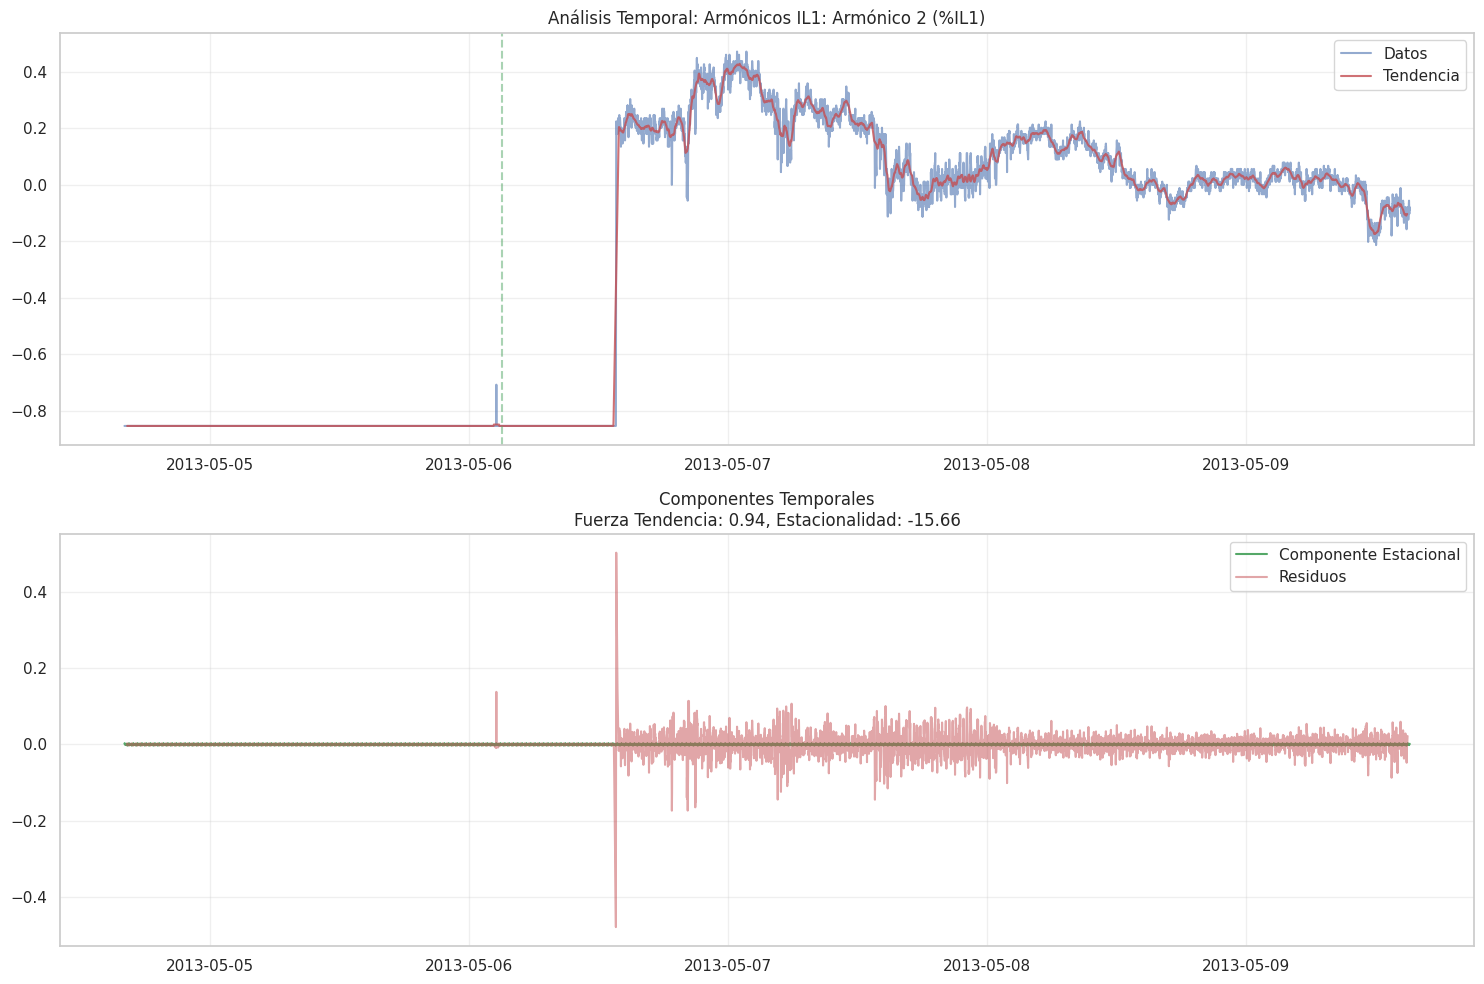

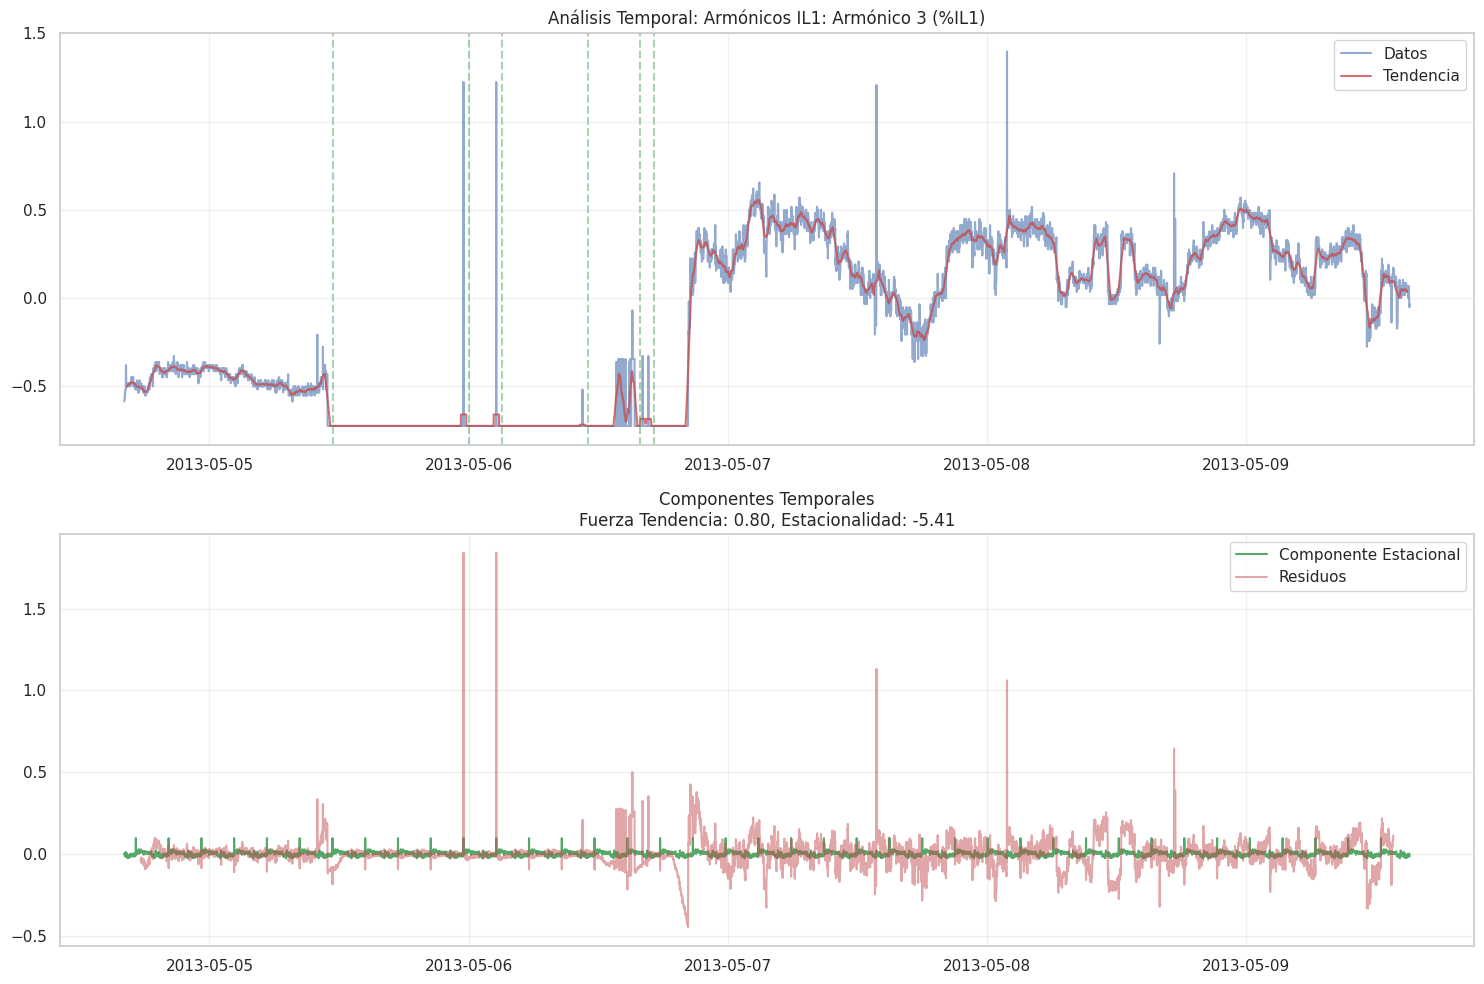

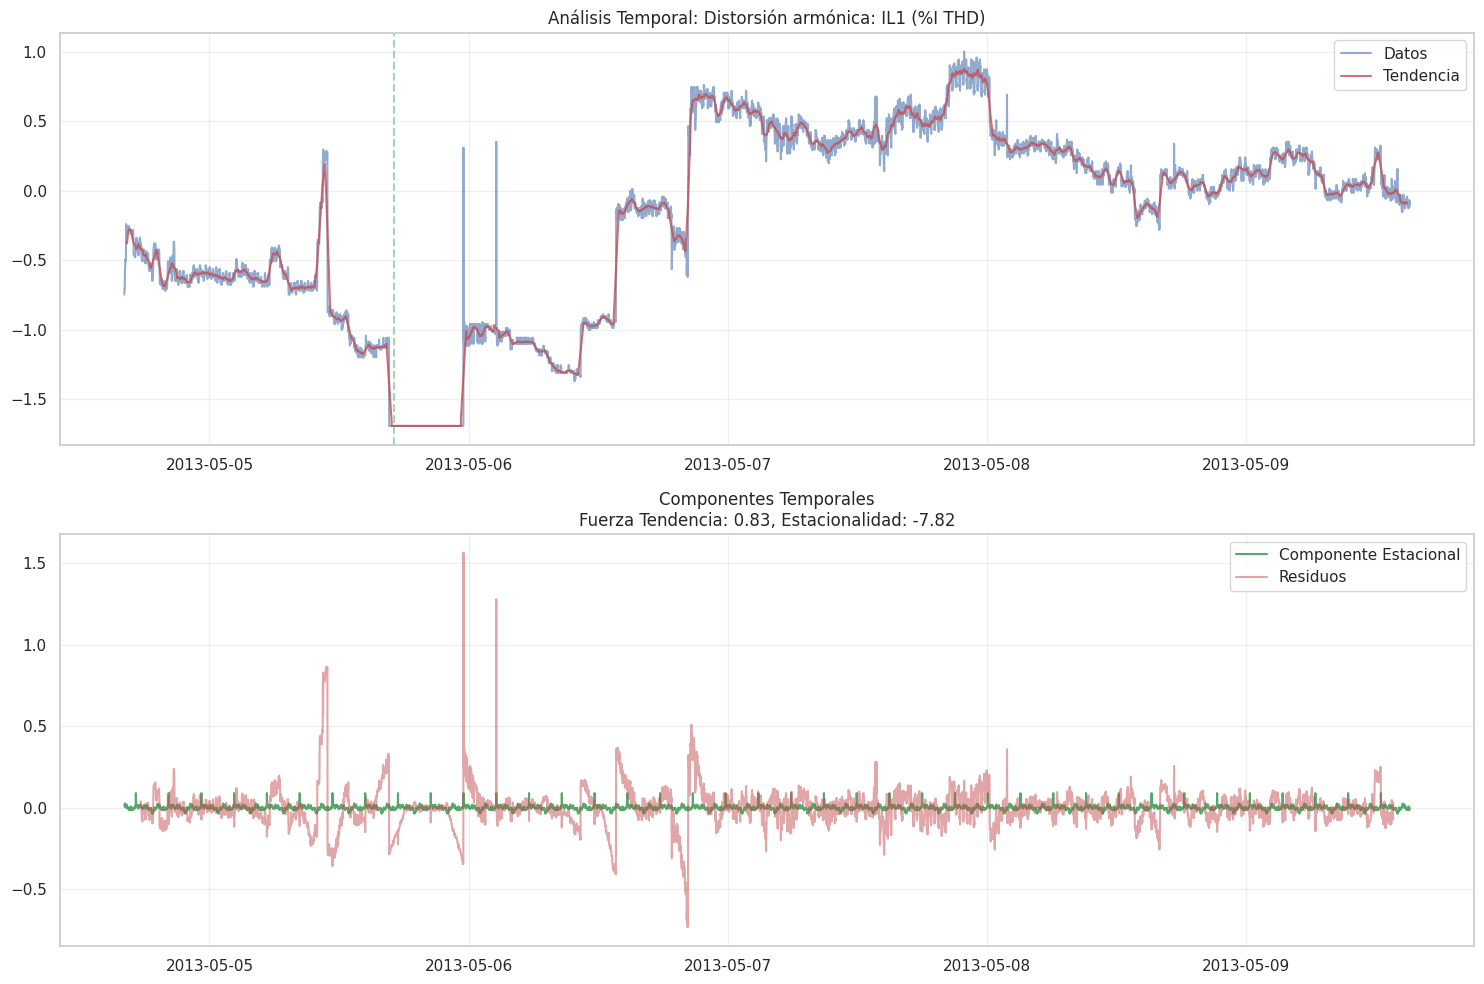

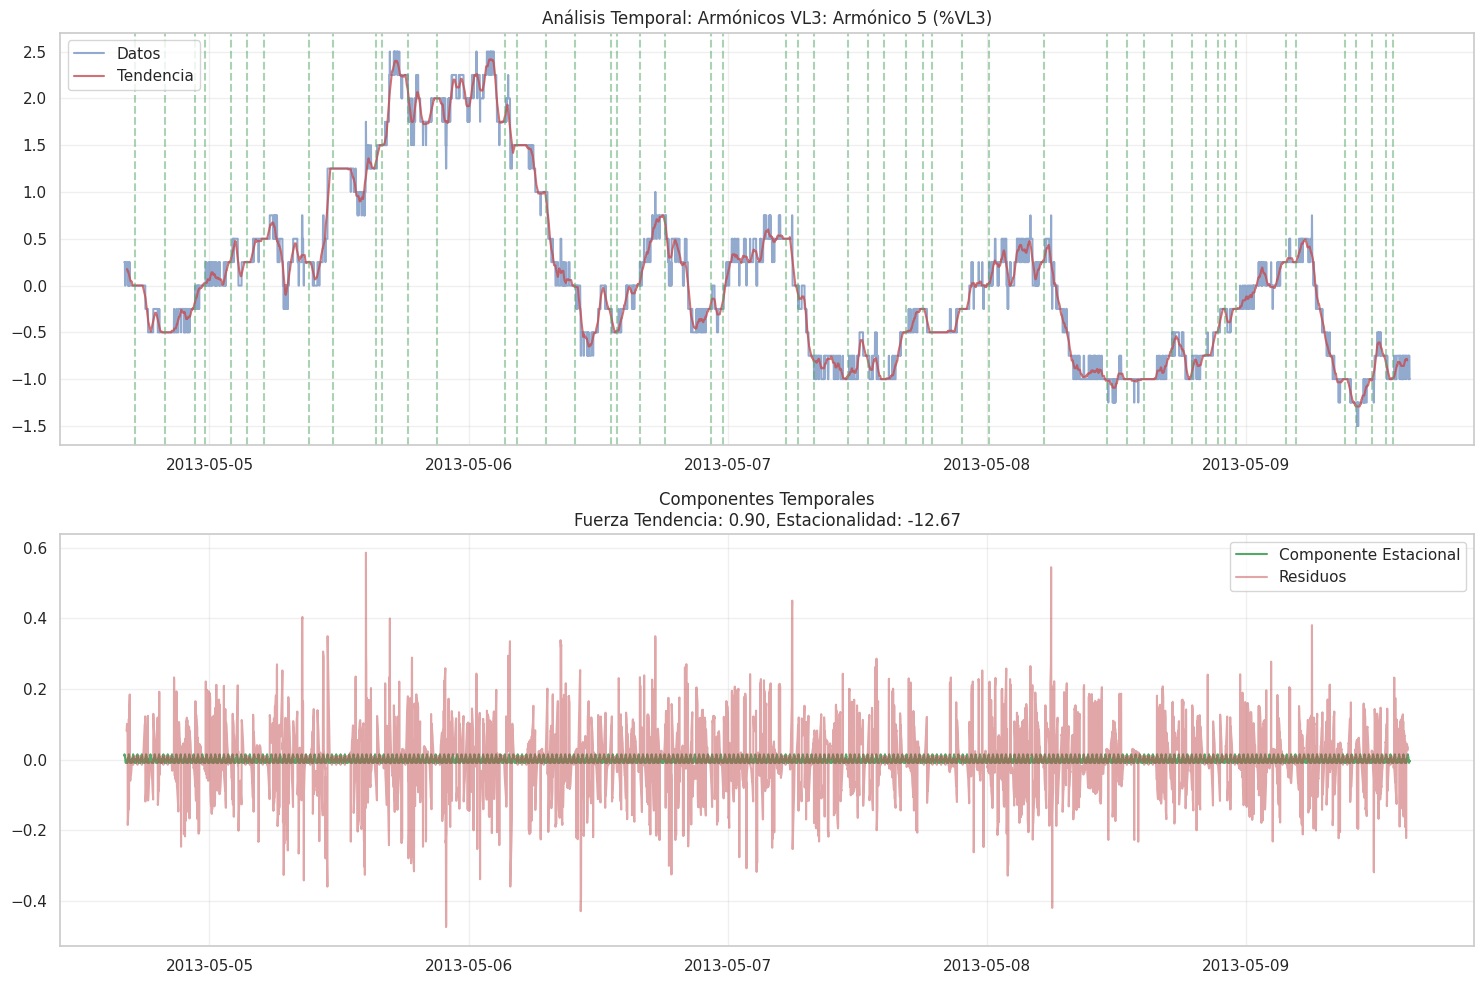

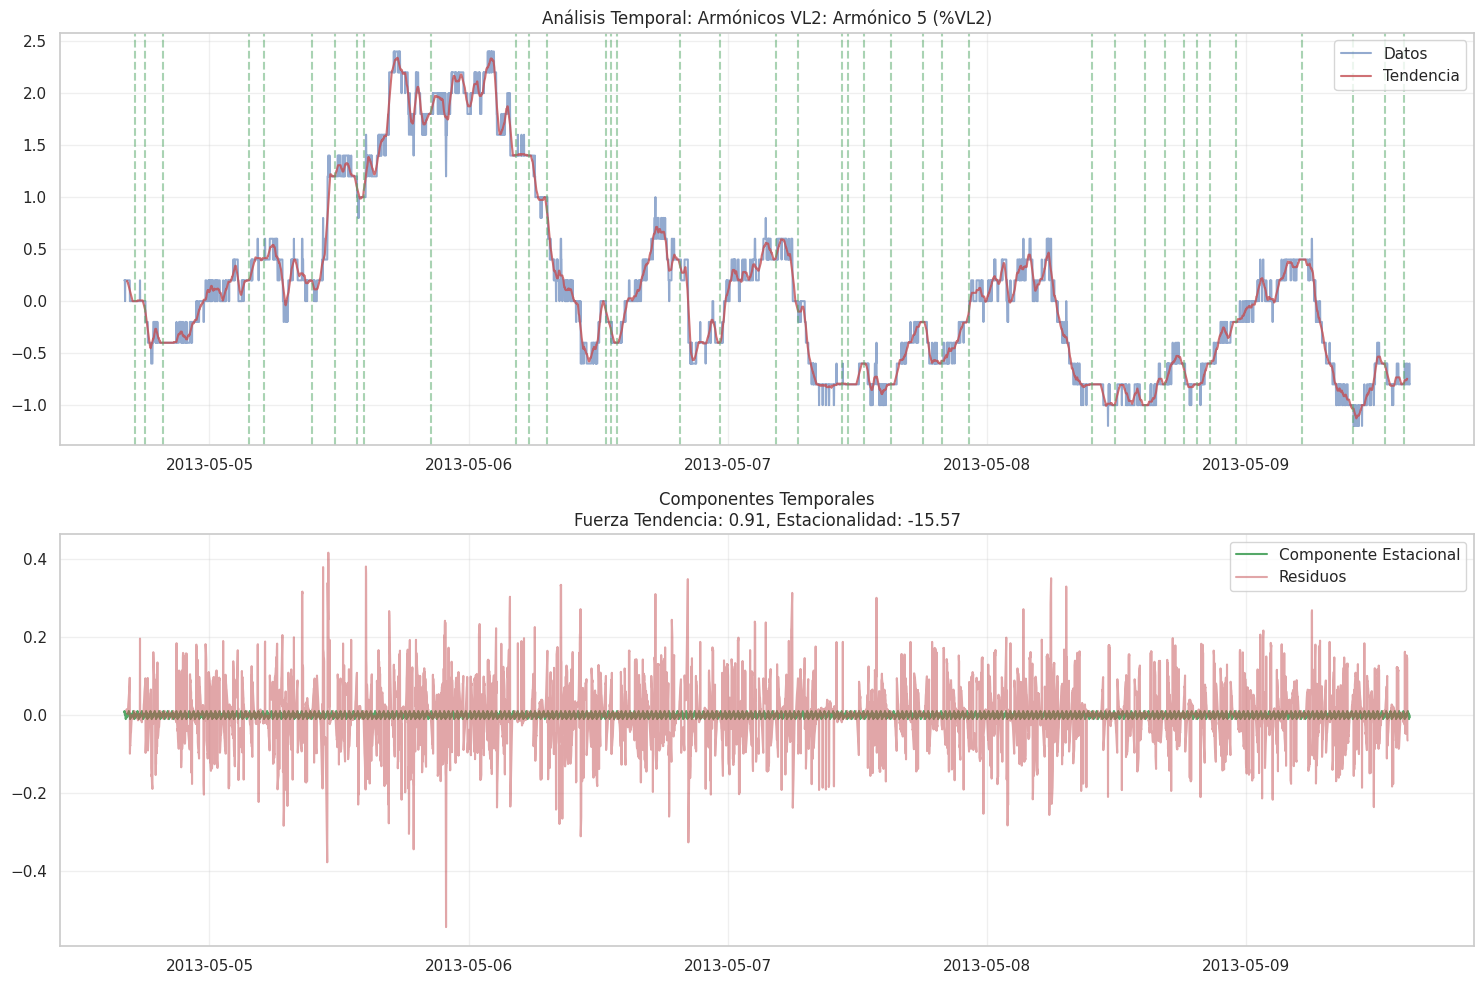


Variables más importantes:
Armónicos IL1: Armónico 2 (%IL1): 0.791
Armónicos IL1: Armónico 3 (%IL1): 0.771
Distorsión armónica: IL1 (%I THD): 0.754
Armónicos VL3: Armónico 5 (%VL3): 0.732
Armónicos VL2: Armónico 5 (%VL2): 0.729
Armónicos VL1: Armónico 5 (%VL1): 0.719
Armónicos IL2: Armónico 7 (%IL2): 0.709
Corriente: L1 (A): 0.706
Armónicos IL1: Armónico 7 (%IL1): 0.703
Armónicos IL1: Armónico 5 (%IL1): 0.680


In [3]:
# CELDA 3: Fase 2 - Identificación de Variables Clave
"""
Fase 2: Identificación de Variables Clave
=======================================

Objetivos:
1. Identificar variables críticas para prognosis
2. Evaluar importancia multifactorial
3. Analizar patrones temporales
4. Determinar correlaciones significativas

Características:
- Análisis multidimensional con preservación temporal
- Visualizaciones basadas en timestamps
- Métricas de evaluación temporal
- Categorización de variables
"""

class VariableAnalyzer:
    def __init__(self):
        """Inicialización del analizador"""
        self._setup_logging()
        self.scaler = RobustScaler()
        self.results = {
            'importance_scores': {},
            'temporal_patterns': {},
            'correlations': {},
            'selected_variables': {},
            'categories': {
                'critical': {},      # Variables críticas para prognosis
                'monitoring': {},    # Variables para monitoreo
                'supporting': {}     # Variables de soporte
            },
            'metrics': {},
            'visualizations': {}
        }

    def _setup_logging(self):
        """Configuración del sistema de logging"""
        self.logger = logging.getLogger(__name__)

    def analyze_variables(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Análisis principal de variables
        
        Args:
            data: DataFrame con datos preprocesados e índice temporal
            
        Returns:
            Dict con resultados completos del análisis
        """
        try:
            self.logger.info("Iniciando análisis de variables...")
            
            # Preparación de datos
            self.data = data
            self.numeric_data = data.select_dtypes(include=[np.number])
            
            print(f"Analizando {len(self.numeric_data.columns)} variables numéricas...")
            print(f"Rango temporal: {data.index.min()} a {data.index.max()}")
            
            # 1. Análisis de Importancia
            self._analyze_variable_importance()
            
            # 2. Análisis de Patrones Temporales (solo top 5 variables)
            top_vars = self._get_top_variables(5)
            for var in top_vars:
                self._analyze_temporal_patterns_for_variable(var)
            
            # 3. Análisis de Correlaciones
            self._analyze_correlations()
            
            # 4. Selección y Categorización
            self._select_and_categorize_variables()
            
            # 5. Generación de Visualizaciones (solo top 5)
            for var in top_vars:
                self._plot_variable_analysis(var)
            
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error en análisis: {str(e)}")
            return None

    def _calculate_importance_score(self, stats_basic: Dict[str, float], 
                                temporal_stats: Dict[str, float]) -> float:
        """Calcula score combinado de importancia"""
        try:
            weights = {
                'variance': 0.15,
                'temporal_stability': 0.25,
                'trend_strength': 0.3,
                'autocorrelation': 0.3
            }
            
            components = {
                'variance': min(stats_basic['variance'] / stats_basic['range'], 1.0),
                'temporal_stability': temporal_stats.get('temporal_stability', 0),
                'trend_strength': temporal_stats.get('trend_strength', 0),
                'autocorrelation': abs(temporal_stats.get('autocorrelation', 0))
            }
            
            score = sum(components[k] * weights[k] for k in weights)
            return min(max(score, 0), 1)
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de score: {str(e)}")
            return 0.0

    def _get_top_variables(self, n: int = 5) -> List[str]:
        """Obtiene las n variables más importantes"""
        try:
            scores = {k: v['combined_score'] 
                     for k, v in self.results['importance_scores'].items()}
            return [k for k, v in sorted(scores.items(), 
                                       key=lambda x: x[1], 
                                       reverse=True)[:n]]
        except Exception as e:
            self.logger.error(f"Error obteniendo top variables: {str(e)}")
            return []

    def _analyze_correlations(self):
        """Analiza correlaciones entre variables"""
        try:
            corr_matrix = self.numeric_data.corr()
            
            significant_corr = {}
            for col1 in corr_matrix.columns:
                significant = []
                for col2 in corr_matrix.columns:
                    if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.7:
                        significant.append({
                            'variable': col2,
                            'correlation': float(corr_matrix.loc[col1, col2])
                        })
                if significant:
                    significant_corr[col1] = significant
            
            self.results['correlations'] = significant_corr
            
        except Exception as e:
            self.logger.error(f"Error en análisis de correlaciones: {str(e)}")

    def _analyze_temporal_patterns_for_variable(self, variable: str):
        """Analiza patrones temporales para una variable específica"""
        try:
            series = self.numeric_data[variable]
            
            # Descomposición temporal
            decomposition = seasonal_decompose(
                series.fillna(method='ffill'),
                period=self._estimate_seasonality_period(series)
            )
            
            trend = decomposition.trend
            seasonal = decomposition.seasonal
            residual = decomposition.resid
            
            self.results['temporal_patterns'][variable] = {
                'trend_strength': float(1 - (residual.std() / series.std())),
                'seasonal_strength': float(1 - (residual.std() / seasonal.std())),
                'change_points': self._detect_change_points(series)
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis temporal de {variable}: {str(e)}")


    def _analyze_variable_importance(self):
        """Análisis de importancia de variables con enfoque temporal"""
        try:
            for column in self.numeric_data.columns:
                series = self.numeric_data[column]
                
                # 1. Estadísticas básicas
                stats_basic = {
                    'variance': float(series.var()),
                    'std': float(series.std()),
                    'range': float(series.max() - series.min()),
                    'iqr': float(series.quantile(0.75) - series.quantile(0.25))
                }
                
                # 2. Análisis temporal
                temporal_stats = self._calculate_temporal_stats(series)
                
                # 3. Score combinado
                combined_score = self._calculate_importance_score(stats_basic, temporal_stats)
                
                self.results['importance_scores'][column] = {
                    'statistics': stats_basic,
                    'temporal_analysis': temporal_stats,
                    'combined_score': combined_score
                }
                
        except Exception as e:
            self.logger.error(f"Error en análisis de importancia: {str(e)}")

    def _calculate_temporal_stats(self, series: pd.Series) -> Dict[str, float]:
        """Calcula estadísticas temporales para una serie"""
        try:
            # Calcular cambios temporales
            changes = series.diff()
            
            return {
                'trend_strength': float(self._calculate_trend_strength(series)),
                'rate_of_change': float(changes.std()),
                'temporal_stability': float(1.0 - (changes.abs().mean() / series.std())),
                'autocorrelation': float(acf(series.fillna(method='ffill'), nlags=1)[1])
            }
        except Exception as e:
            self.logger.error(f"Error en estadísticas temporales: {str(e)}")
            return {}

    def _calculate_trend_strength(self, series: pd.Series) -> float:
        """Calcula la fuerza de la tendencia temporal"""
        try:
            # Usar índice temporal para regresión
            time_numeric = np.arange(len(series))
            slope, _, r_value, _, _ = stats.linregress(time_numeric, series.fillna(method='ffill'))
            return abs(r_value)
        except Exception as e:
            self.logger.error(f"Error calculando tendencia: {str(e)}")
            return 0.0

    def _estimate_seasonality_period(self, series: pd.Series) -> int:
        """Estima el período de estacionalidad"""
        try:
            # Calcular autocorrelación
            acf_values = acf(series.fillna(method='ffill'), nlags=min(len(series)-1, 365))
            
            # Encontrar picos en la autocorrelación
            peaks = [i for i in range(1, len(acf_values)-1) 
                    if acf_values[i] > acf_values[i-1] and acf_values[i] > acf_values[i+1]]
            
            if peaks:
                return peaks[0]  # Retornar el primer pico
            return 24  # Período por defecto (24 horas)
            
        except Exception as e:
            self.logger.error(f"Error estimando estacionalidad: {str(e)}")
            return 24

    def _detect_change_points(self, series: pd.Series) -> List[Dict[str, Any]]:
        """Detecta puntos de cambio en la serie temporal"""
        try:
            changes = []
            window_size = min(30, len(series)//10)
            
            # Calcular medias móviles
            rolling_mean = series.rolling(window=window_size).mean()
            rolling_std = series.rolling(window=window_size).std()
            
            # Detectar cambios significativos
            for i in range(window_size, len(series)-1):
                if abs(rolling_mean.iloc[i] - rolling_mean.iloc[i-1]) > 2 * rolling_std.iloc[i]:
                    changes.append({
                        'timestamp': str(series.index[i]),
                        'magnitude': float(abs(rolling_mean.iloc[i] - rolling_mean.iloc[i-1])),
                        'direction': 'increase' if rolling_mean.iloc[i] > rolling_mean.iloc[i-1] else 'decrease'
                    })
            
            return changes
            
        except Exception as e:
            self.logger.error(f"Error detectando cambios: {str(e)}")
            return []

    def _select_and_categorize_variables(self):
        """Selecciona y categoriza variables según su importancia"""
        try:
            # Ordenar variables por score de importancia
            importance_scores = {
                k: v['combined_score'] 
                for k, v in self.results['importance_scores'].items()
            }
            sorted_vars = sorted(
                importance_scores.items(), 
                key=lambda x: x[1], 
                reverse=True
            )
            
            # Categorizar variables
            n_vars = len(sorted_vars)
            for i, (var, score) in enumerate(sorted_vars):
                if i < n_vars * 0.2:  # Top 20%
                    category = 'critical'
                elif i < n_vars * 0.5:  # Top 50%
                    category = 'monitoring'
                else:
                    category = 'supporting'
                
                self.results['categories'][category][var] = {
                    'importance_score': score,
                    'rank': i + 1
                }
            
            # Seleccionar variables más importantes
            self.results['selected_variables'] = {
                var: score for var, score in sorted_vars[:int(n_vars * 0.2)]
            }
            
        except Exception as e:
            self.logger.error(f"Error en selección de variables: {str(e)}")

    def _plot_variable_analysis(self, column: str):
        """Genera visualización temporal para una variable"""
        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
            
            # Serie temporal
            series = self.numeric_data[column]
            ax1.plot(series.index, series.values, 'b-', label='Datos', alpha=0.6)
            
            # Tendencia usando rolling mean en lugar de HP filter
            window = min(30, len(series)//10)
            trend = series.rolling(window=window, center=True).mean()
            ax1.plot(series.index, trend, 'r-', label='Tendencia', alpha=0.8)
            
            # Puntos de cambio
            if column in self.results['temporal_patterns']:
                changes = self.results['temporal_patterns'][column]['change_points']
                for change in changes:
                    change_time = pd.to_datetime(change['timestamp'])
                    ax1.axvline(x=change_time, color='g', linestyle='--', alpha=0.5)
            
            ax1.set_title(f'Análisis Temporal: {column}')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Descomposición
            try:
                decomposition = seasonal_decompose(
                    series.fillna(method='ffill'),
                    period=self._estimate_seasonality_period(series)
                )
                ax2.plot(series.index, decomposition.seasonal, 'g-', 
                        label='Componente Estacional')
                ax2.plot(series.index, decomposition.resid, 'r-', 
                        label='Residuos', alpha=0.5)
                
                # Agregar información de patrones
                if column in self.results['temporal_patterns']:
                    pattern = self.results['temporal_patterns'][column]
                    ax2.set_title(f'Componentes Temporales\n'
                                f'Fuerza Tendencia: {pattern["trend_strength"]:.2f}, '
                                f'Estacionalidad: {pattern["seasonal_strength"]:.2f}')
            except Exception as e:
                ax2.set_title('No se pudieron calcular componentes temporales')
                self.logger.warning(f"Error en descomposición de {column}: {str(e)}")
            
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            self.logger.error(f"Error en visualización de {column}: {str(e)}")

# Función de prueba
def test_variable_analysis(data: pd.DataFrame):
    """Prueba el análisis de variables"""
    try:
        print("\n=== PRUEBA DE ANÁLISIS DE VARIABLES ===\n")
        
        analyzer = VariableAnalyzer()
        results = analyzer.analyze_variables(data)
        
        if results:
            print("\nVariables más importantes:")
            importance_scores = {k: v['combined_score'] 
                              for k, v in results['importance_scores'].items()}
            
            for var, score in sorted(importance_scores.items(), 
                                   key=lambda x: x[1], reverse=True)[:10]:
                print(f"{var}: {score:.3f}")
                
            return results
        else:
            print("Error en análisis de variables")
            return None
            
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None

# Ejecutar prueba si hay datos procesados
if 'processed_data' in globals():
    variable_analysis_results = test_variable_analysis(processed_data)
else:
    print("Error: Ejecutar primero el preprocesamiento de datos")


2024-12-24 10:47:35,622 - INFO - Iniciando aprendizaje de línea base...
2024-12-24 10:47:35,628 - INFO - Analizando variable: Armónicos IL1: Armónico 2 (%IL1)



Iniciando prueba de aprendizaje de línea base...

=== PRUEBA DE APRENDIZAJE DE LÍNEA BASE ===


Analizando 12 variables principales:
- Armónicos IL1: Armónico 2 (%IL1)
- Armónicos IL1: Armónico 3 (%IL1)
- Distorsión armónica: IL1 (%I THD)
- Armónicos VL3: Armónico 5 (%VL3)
- Armónicos VL2: Armónico 5 (%VL2)
- Armónicos VL1: Armónico 5 (%VL1)
- Armónicos IL2: Armónico 7 (%IL2)
- Corriente: L1 (A)
- Armónicos IL1: Armónico 7 (%IL1)
- Armónicos IL1: Armónico 5 (%IL1)
- Armónicos VL1: Armónico 11 (%VL1)
- Tensión: L2 - L3 (V)


2024-12-24 10:47:36,103 - INFO - Analizando variable: Armónicos IL1: Armónico 3 (%IL1)
2024-12-24 10:47:36,758 - INFO - Analizando variable: Distorsión armónica: IL1 (%I THD)
2024-12-24 10:47:37,270 - INFO - Analizando variable: Armónicos VL3: Armónico 5 (%VL3)
2024-12-24 10:47:37,850 - INFO - Analizando variable: Armónicos VL2: Armónico 5 (%VL2)
2024-12-24 10:47:38,236 - INFO - Analizando variable: Armónicos VL1: Armónico 5 (%VL1)
2024-12-24 10:47:38,684 - INFO - Analizando variable: Armónicos IL2: Armónico 7 (%IL2)
2024-12-24 10:47:39,003 - INFO - Analizando variable: Corriente: L1 (A)
2024-12-24 10:47:39,317 - INFO - Analizando variable: Armónicos IL1: Armónico 7 (%IL1)
2024-12-24 10:47:39,653 - INFO - Analizando variable: Armónicos IL1: Armónico 5 (%IL1)
2024-12-24 10:47:40,064 - INFO - Analizando variable: Armónicos VL1: Armónico 11 (%VL1)
2024-12-24 10:47:40,397 - INFO - Analizando variable: Tensión: L2 - L3 (V)
2024-12-24 10:47:40,724 - INFO - Aprendizaje de línea base completad


Variables analizadas:

Analizando Armónicos IL1: Armónico 2 (%IL1):


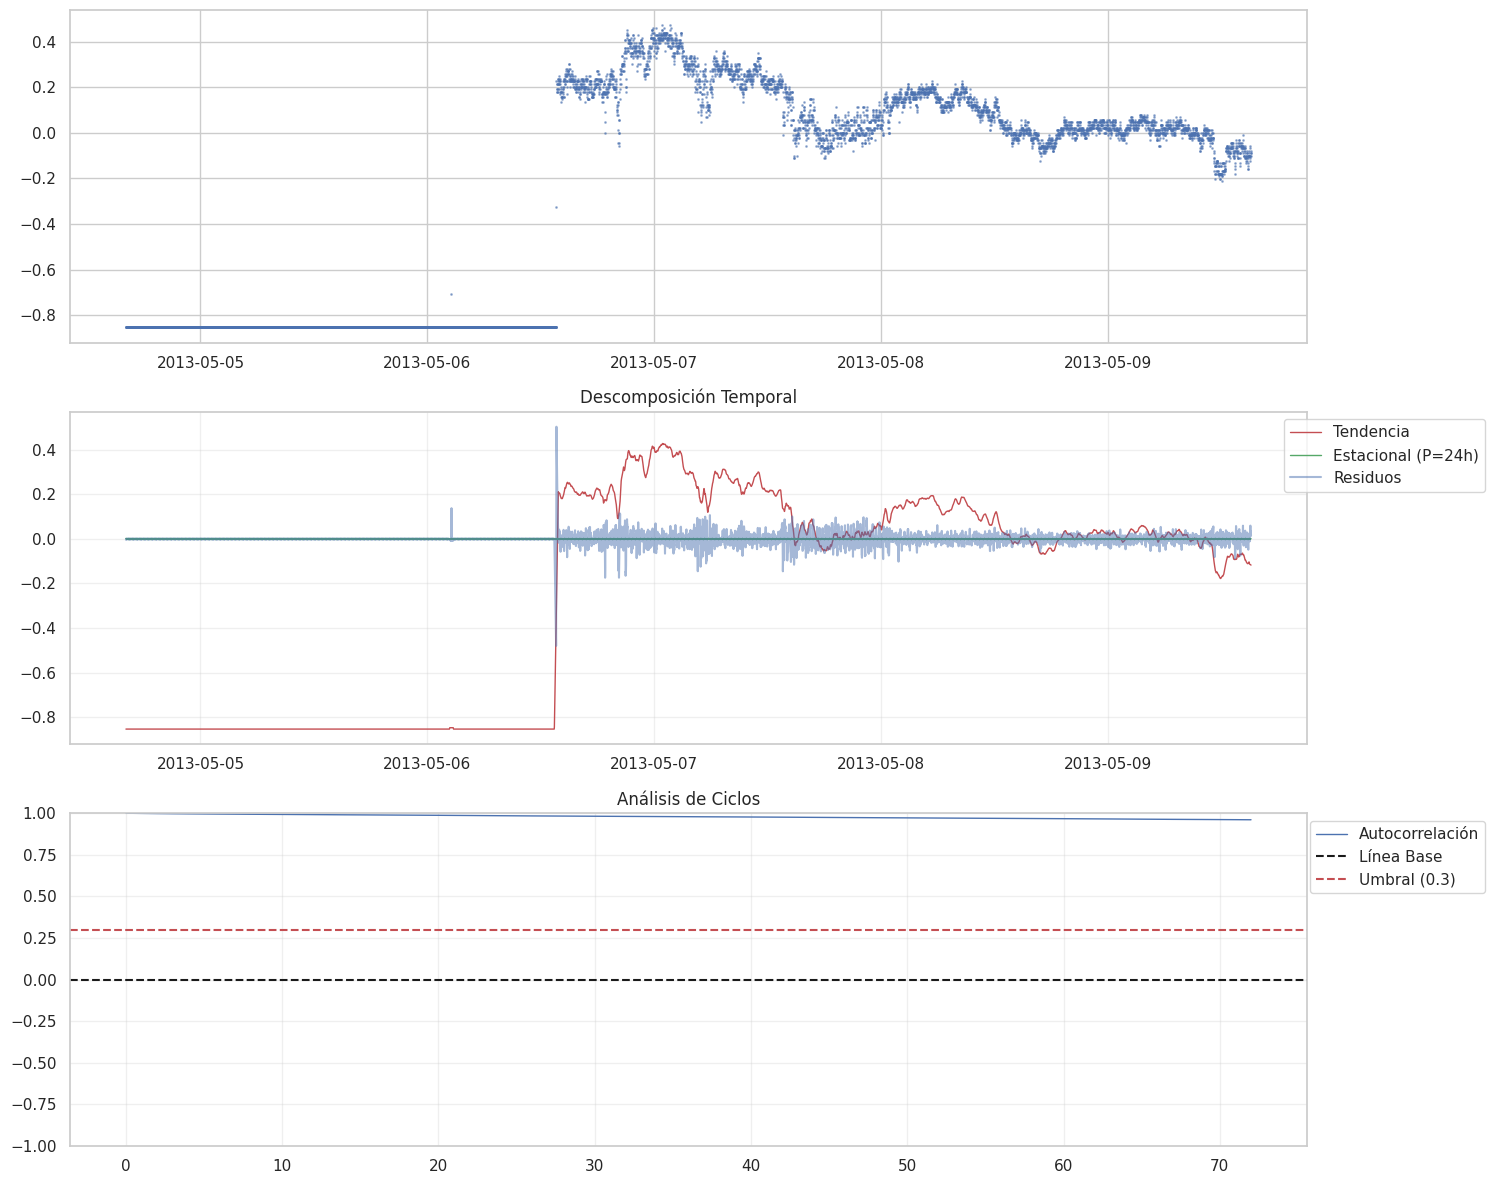


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: -0.258
std: 0.481
median: 0.000
q25: -0.854
q75: 0.146
min: -0.854
max: 0.472
skewness: -0.327
kurtosis: -1.681

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.737
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos IL1: Armónico 3 (%IL1):


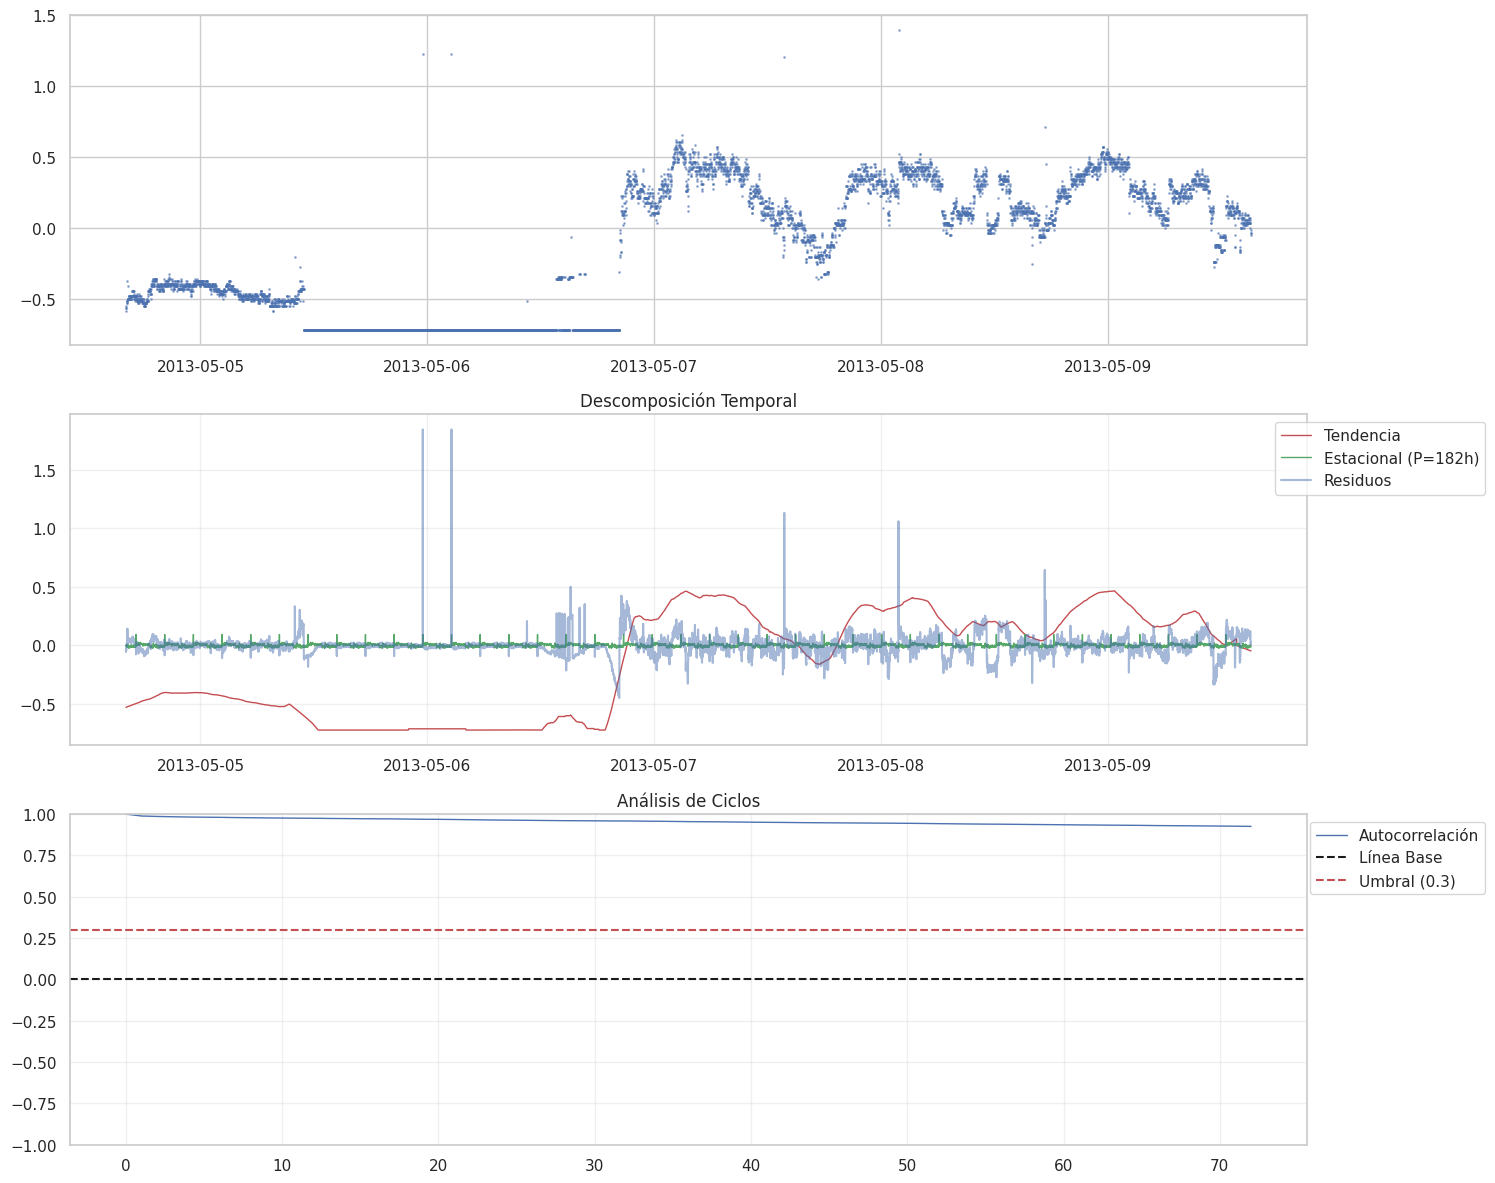


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: -0.146
std: 0.451
median: 0.000
q25: -0.724
q75: 0.276
min: -0.724
max: 1.397
skewness: -0.094
kurtosis: -1.558

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.739
Período estacional: 182
Fuerza estacional: 0.802

Analizando Distorsión armónica: IL1 (%I THD):


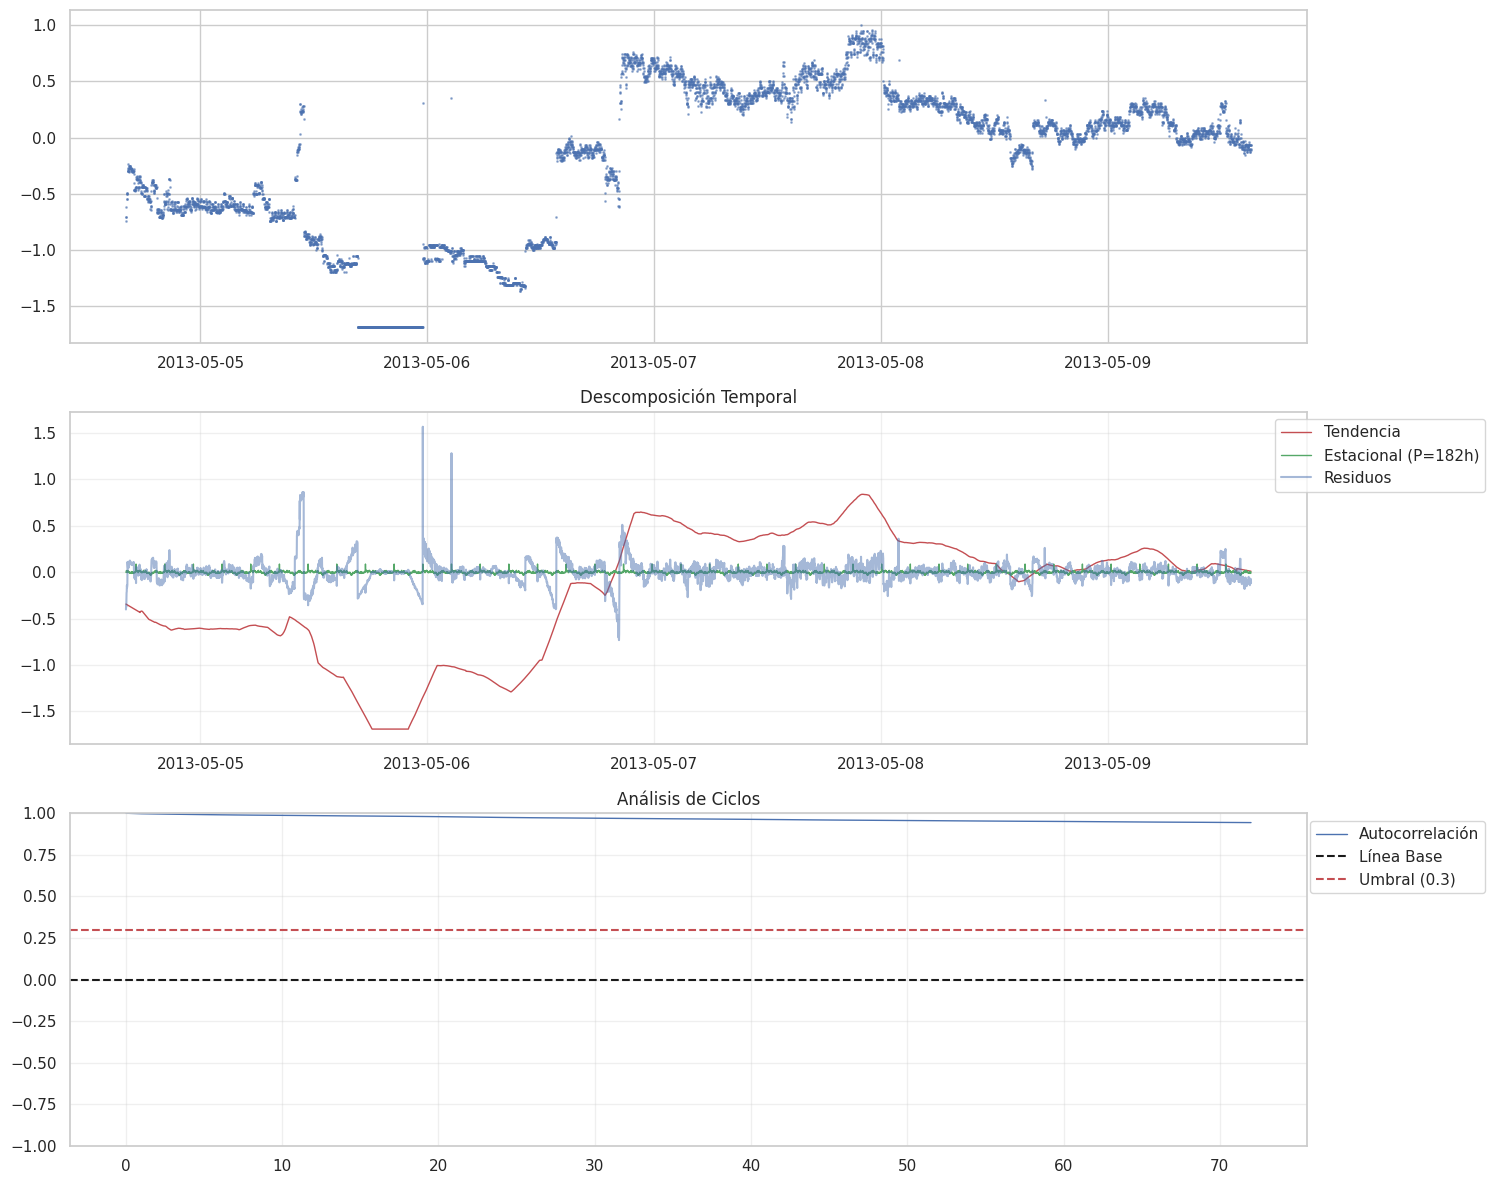


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: -0.207
std: 0.677
median: 0.000
q25: -0.676
q75: 0.324
min: -1.690
max: 1.000
skewness: -0.593
kurtosis: -0.648

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.623
Período estacional: 182
Fuerza estacional: 0.827

Analizando Armónicos VL3: Armónico 5 (%VL3):


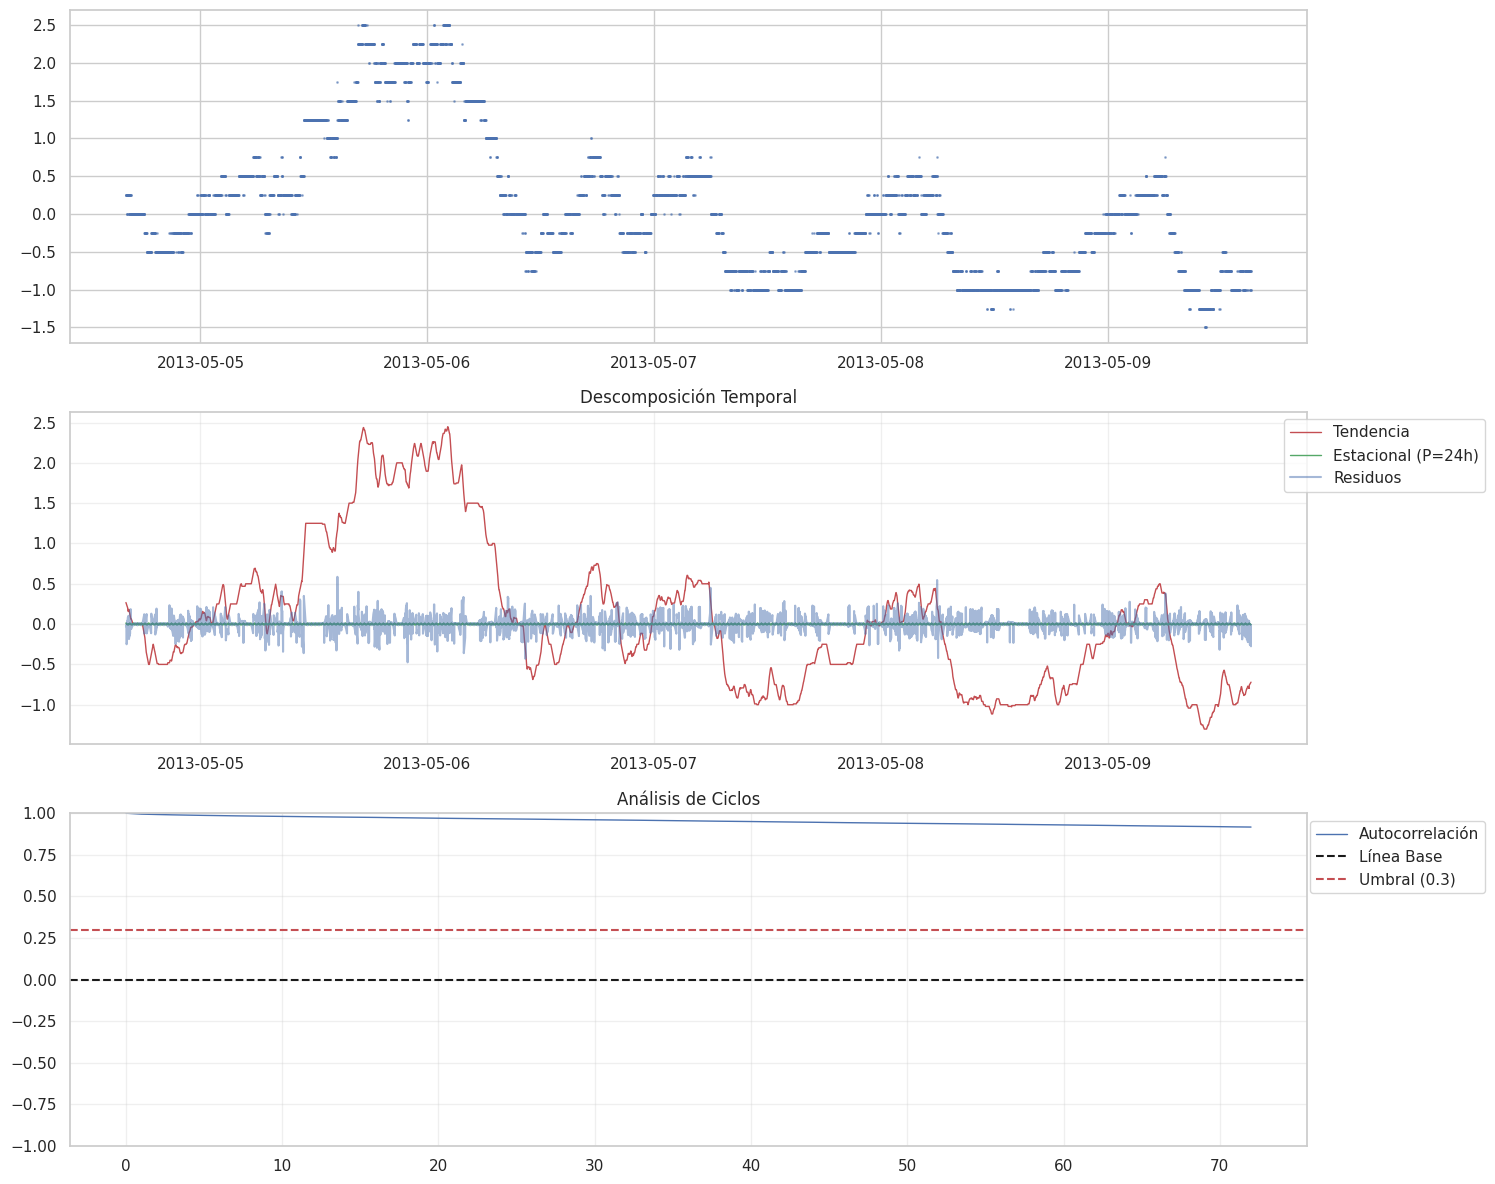


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.082
std: 0.897
median: 0.000
q25: -0.500
q75: 0.500
min: -1.500
max: 2.500
skewness: 0.865
kurtosis: 0.118

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.542
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos VL2: Armónico 5 (%VL2):


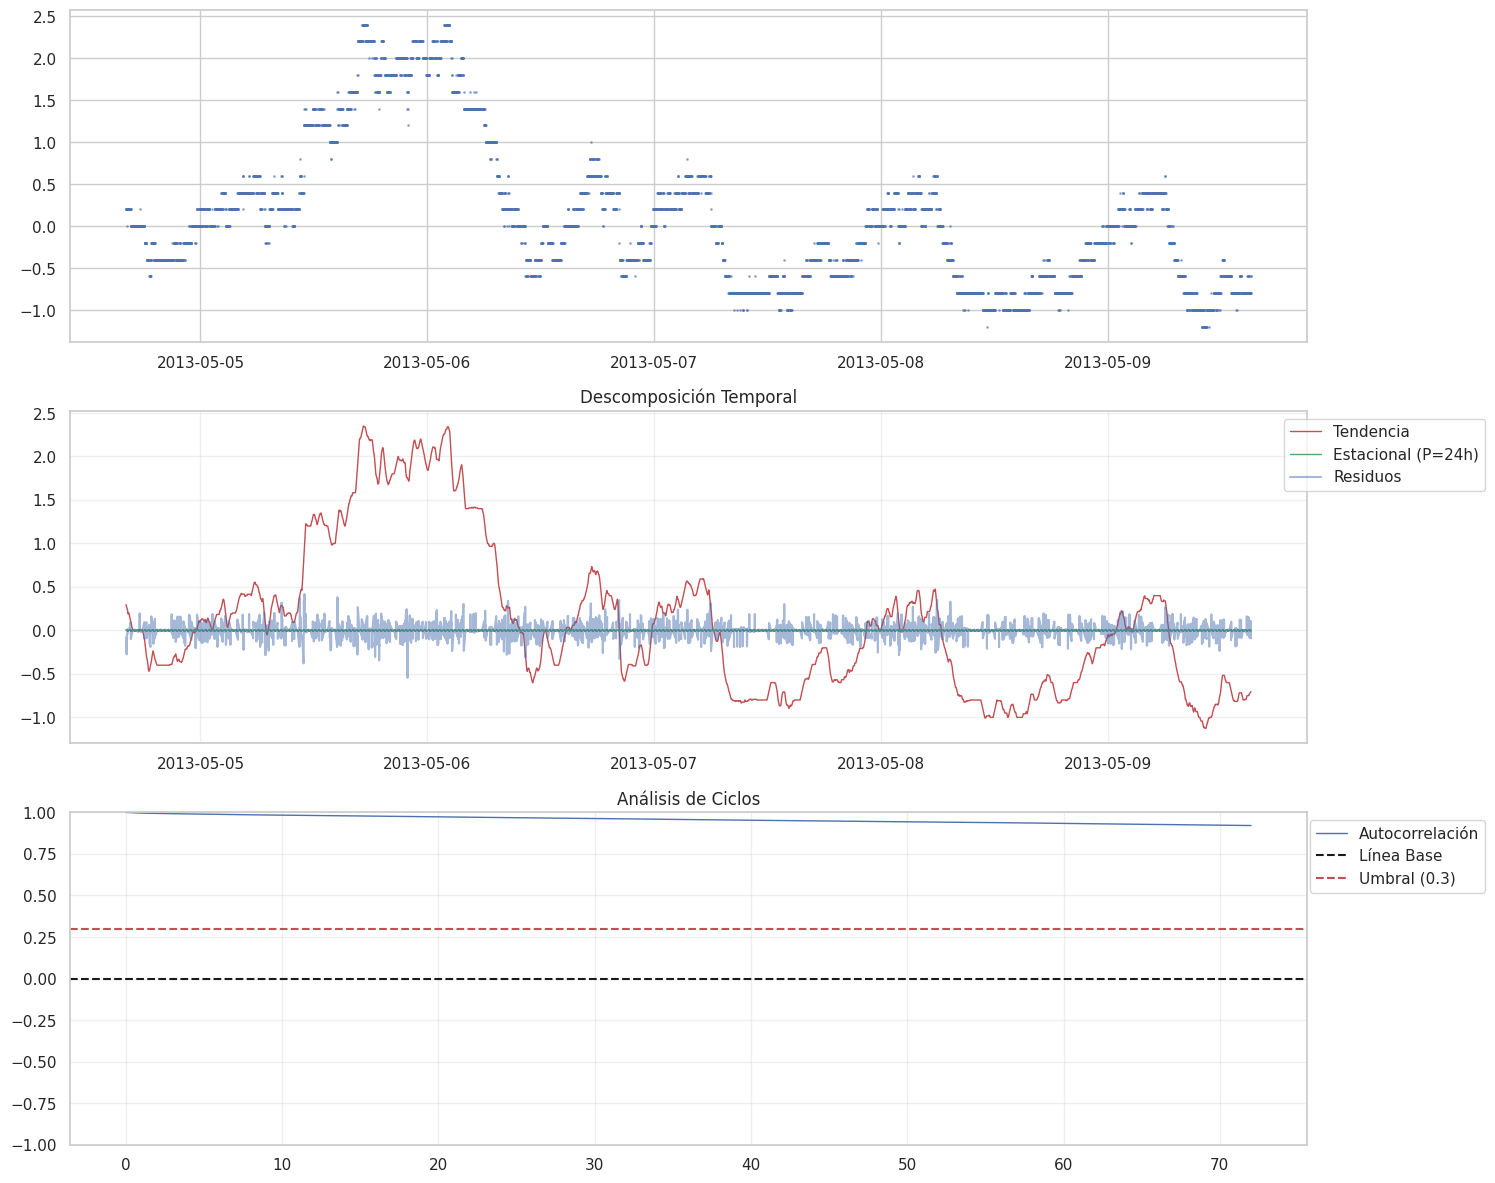


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.106
std: 0.851
median: 0.000
q25: -0.600
q75: 0.400
min: -1.200
max: 2.400
skewness: 0.941
kurtosis: 0.195

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.531
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos VL1: Armónico 5 (%VL1):


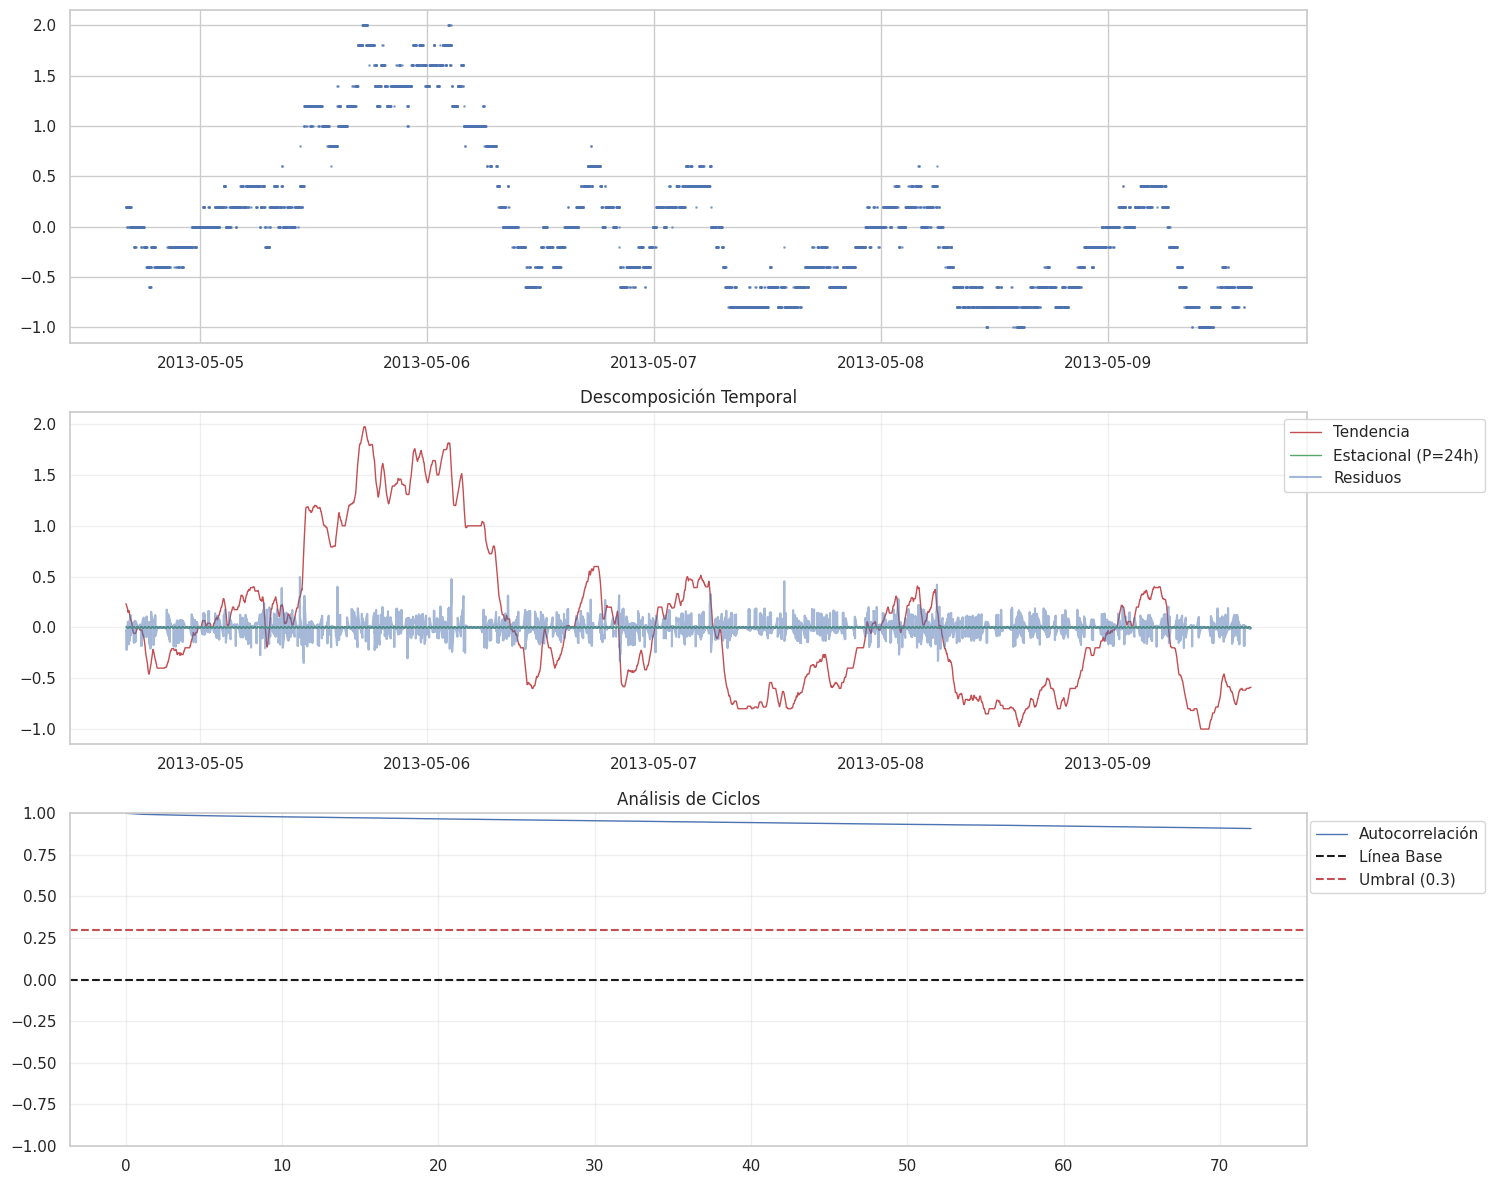


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.041
std: 0.708
median: 0.000
q25: -0.600
q75: 0.400
min: -1.000
max: 2.000
skewness: 0.842
kurtosis: 0.021

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.520
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos IL2: Armónico 7 (%IL2):


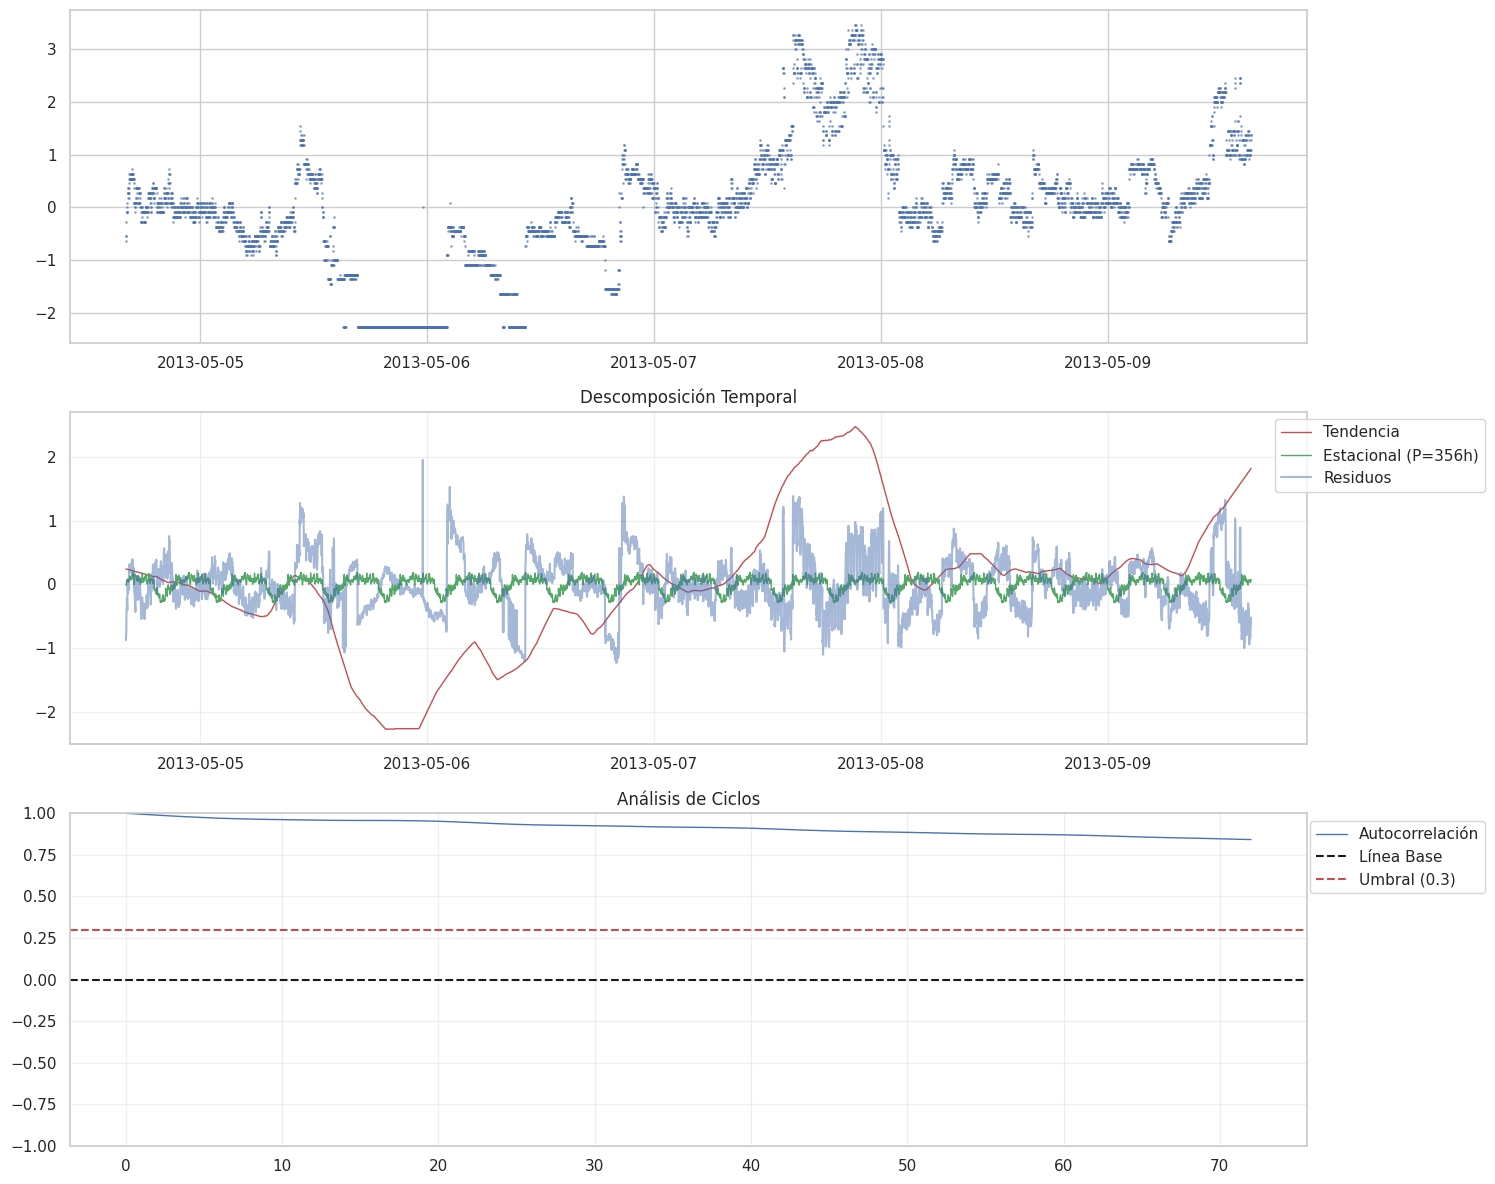


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.003
std: 1.177
median: 0.000
q25: -0.455
q75: 0.545
min: -2.273
max: 3.455
skewness: 0.204
kurtosis: 0.660

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.457
Período estacional: 356
Fuerza estacional: 0.645

Analizando Corriente: L1 (A):


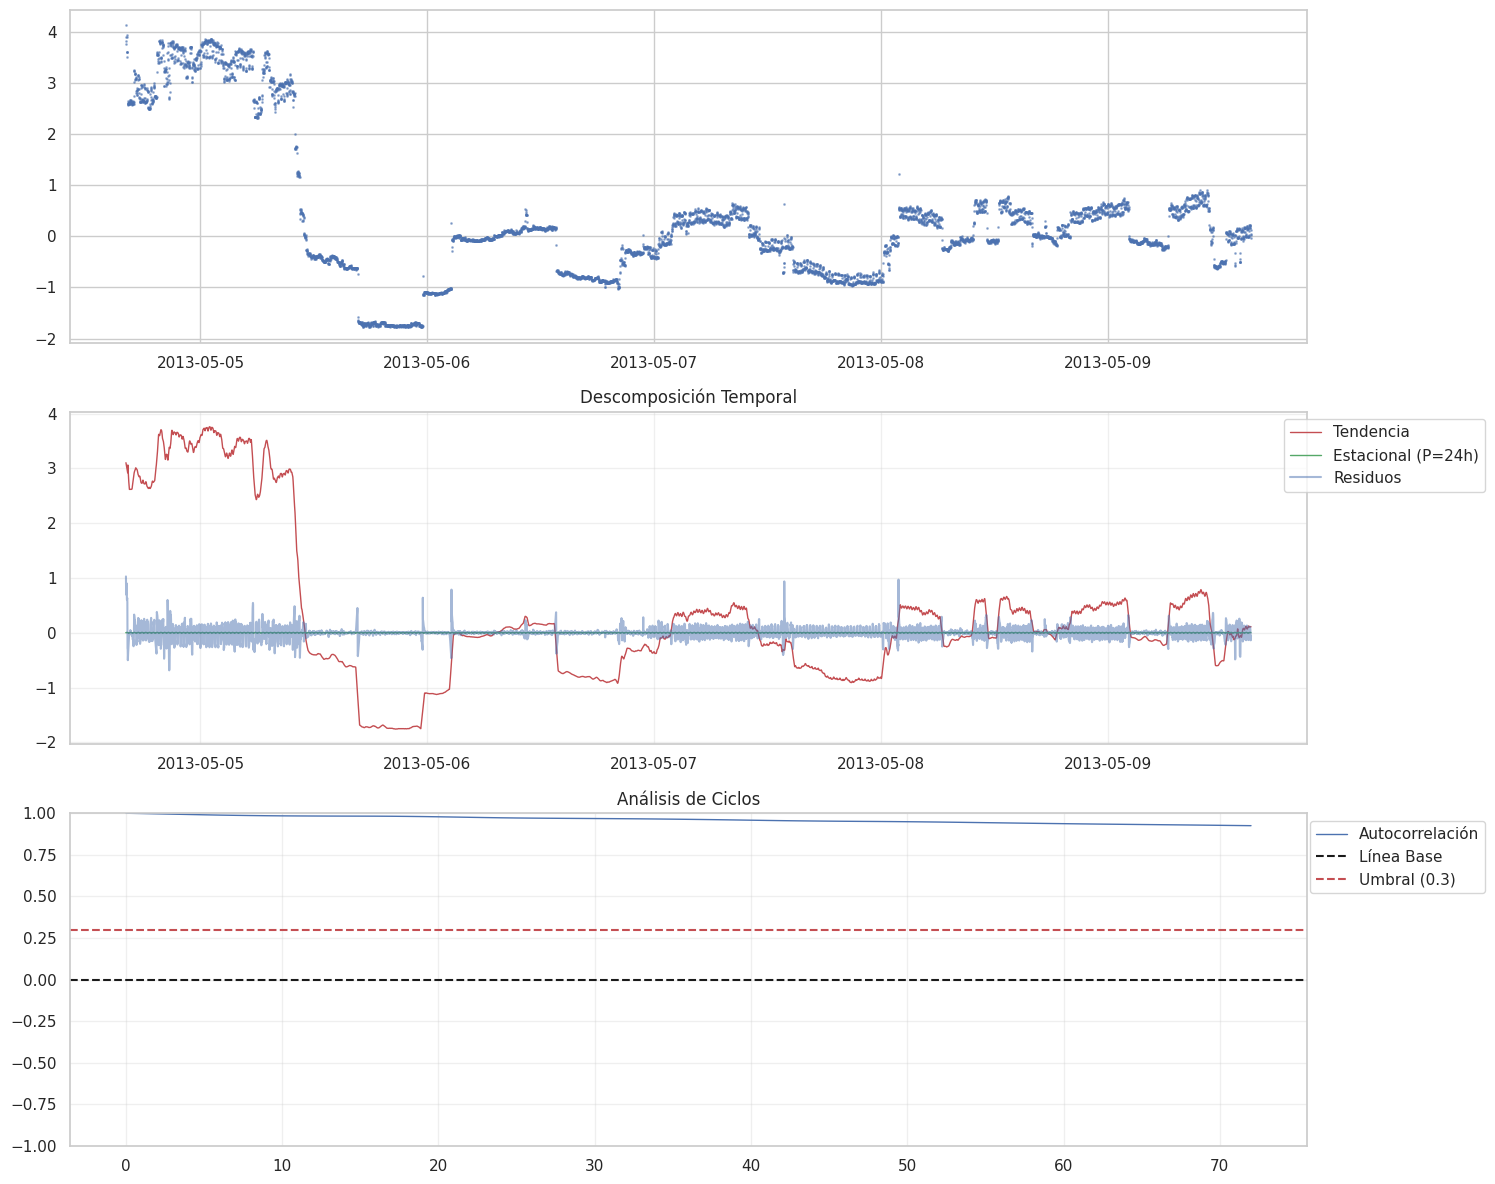


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.313
std: 1.369
median: 0.000
q25: -0.503
q75: 0.497
min: -1.783
max: 4.134
skewness: 1.223
kurtosis: 0.847

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.383
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos IL1: Armónico 7 (%IL1):


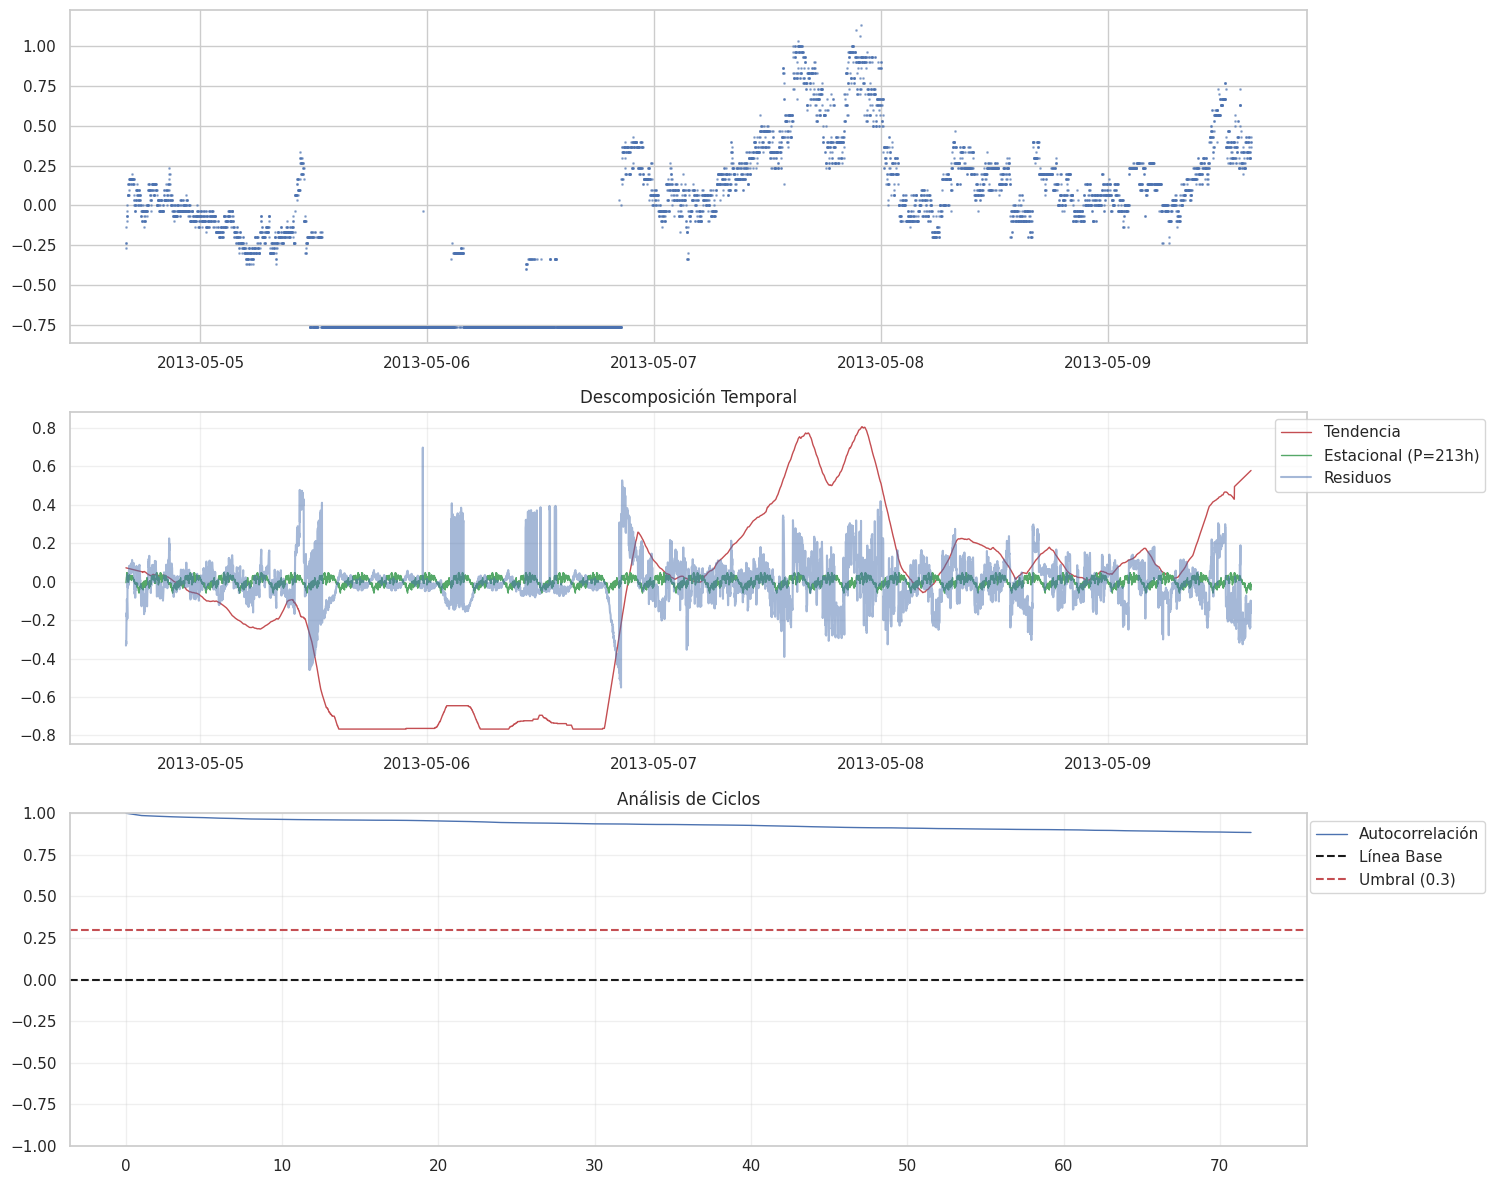


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: -0.087
std: 0.468
median: 0.000
q25: -0.767
q75: 0.233
min: -0.767
max: 1.133
skewness: -0.141
kurtosis: -0.742

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.521
Período estacional: 213
Fuerza estacional: 0.743

Analizando Armónicos IL1: Armónico 5 (%IL1):


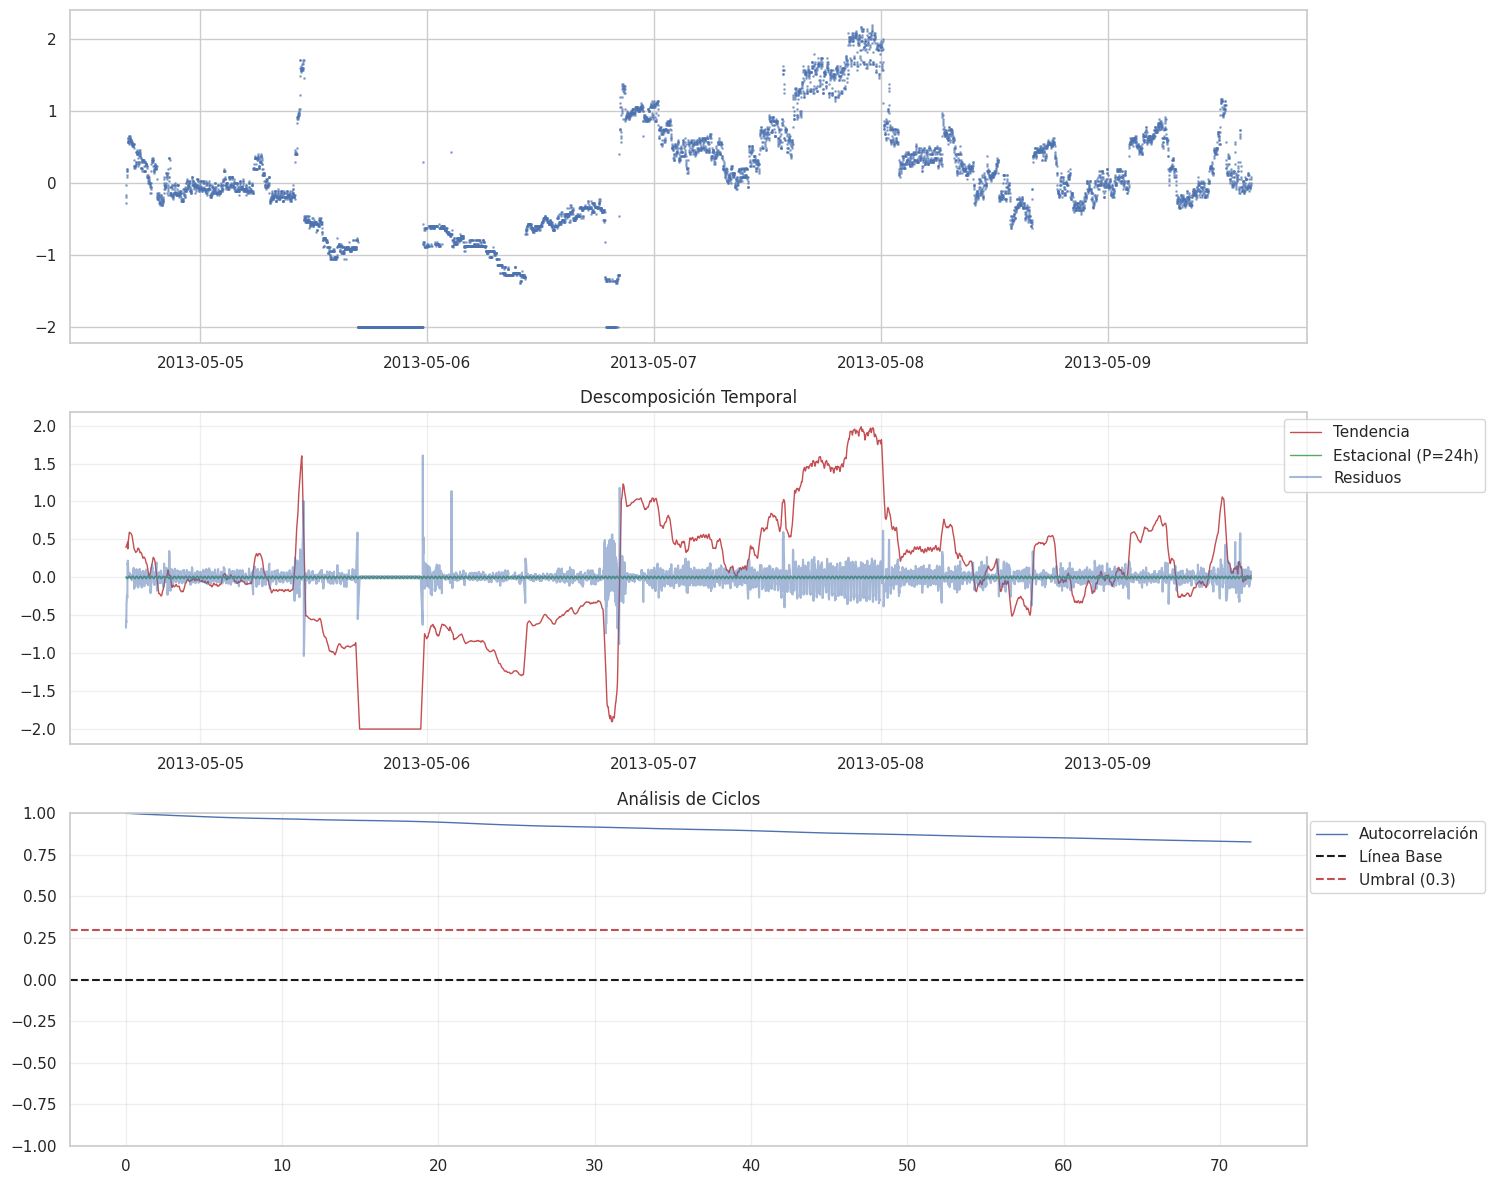


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: -0.000
std: 0.869
median: 0.000
q25: -0.486
q75: 0.514
min: -2.000
max: 2.189
skewness: -0.261
kurtosis: 0.383

Patrones Temporales:
Tendencia: increasing
Fuerza de tendencia: 0.384
Período estacional: 1
Fuerza estacional: 0.000

Analizando Armónicos VL1: Armónico 11 (%VL1):


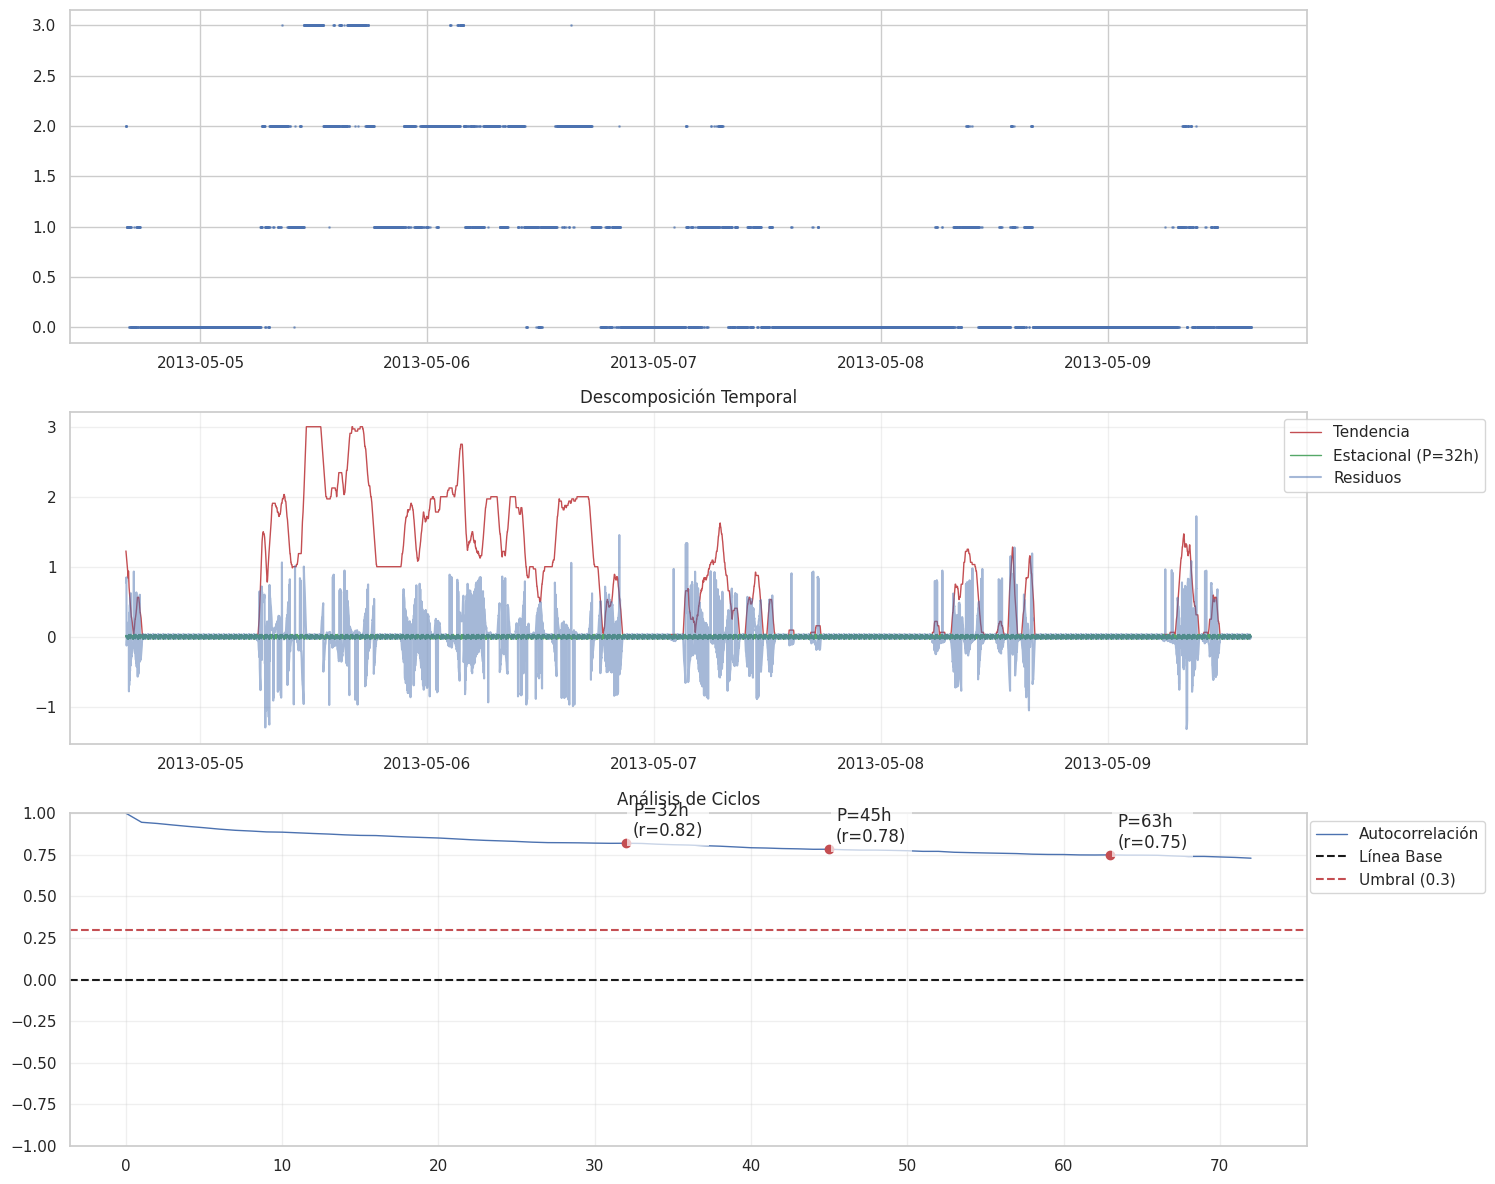


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.651
std: 0.890
median: 0.000
q25: 0.000
q75: 1.000
min: 0.000
max: 3.000
skewness: 1.092
kurtosis: 0.009

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.420
Período estacional: 32
Fuerza estacional: 0.704

Ciclos Principales:
Período: 32, Fuerza: 0.819
Período: 45, Fuerza: 0.783
Período: 63, Fuerza: 0.749

Analizando Tensión: L2 - L3 (V):


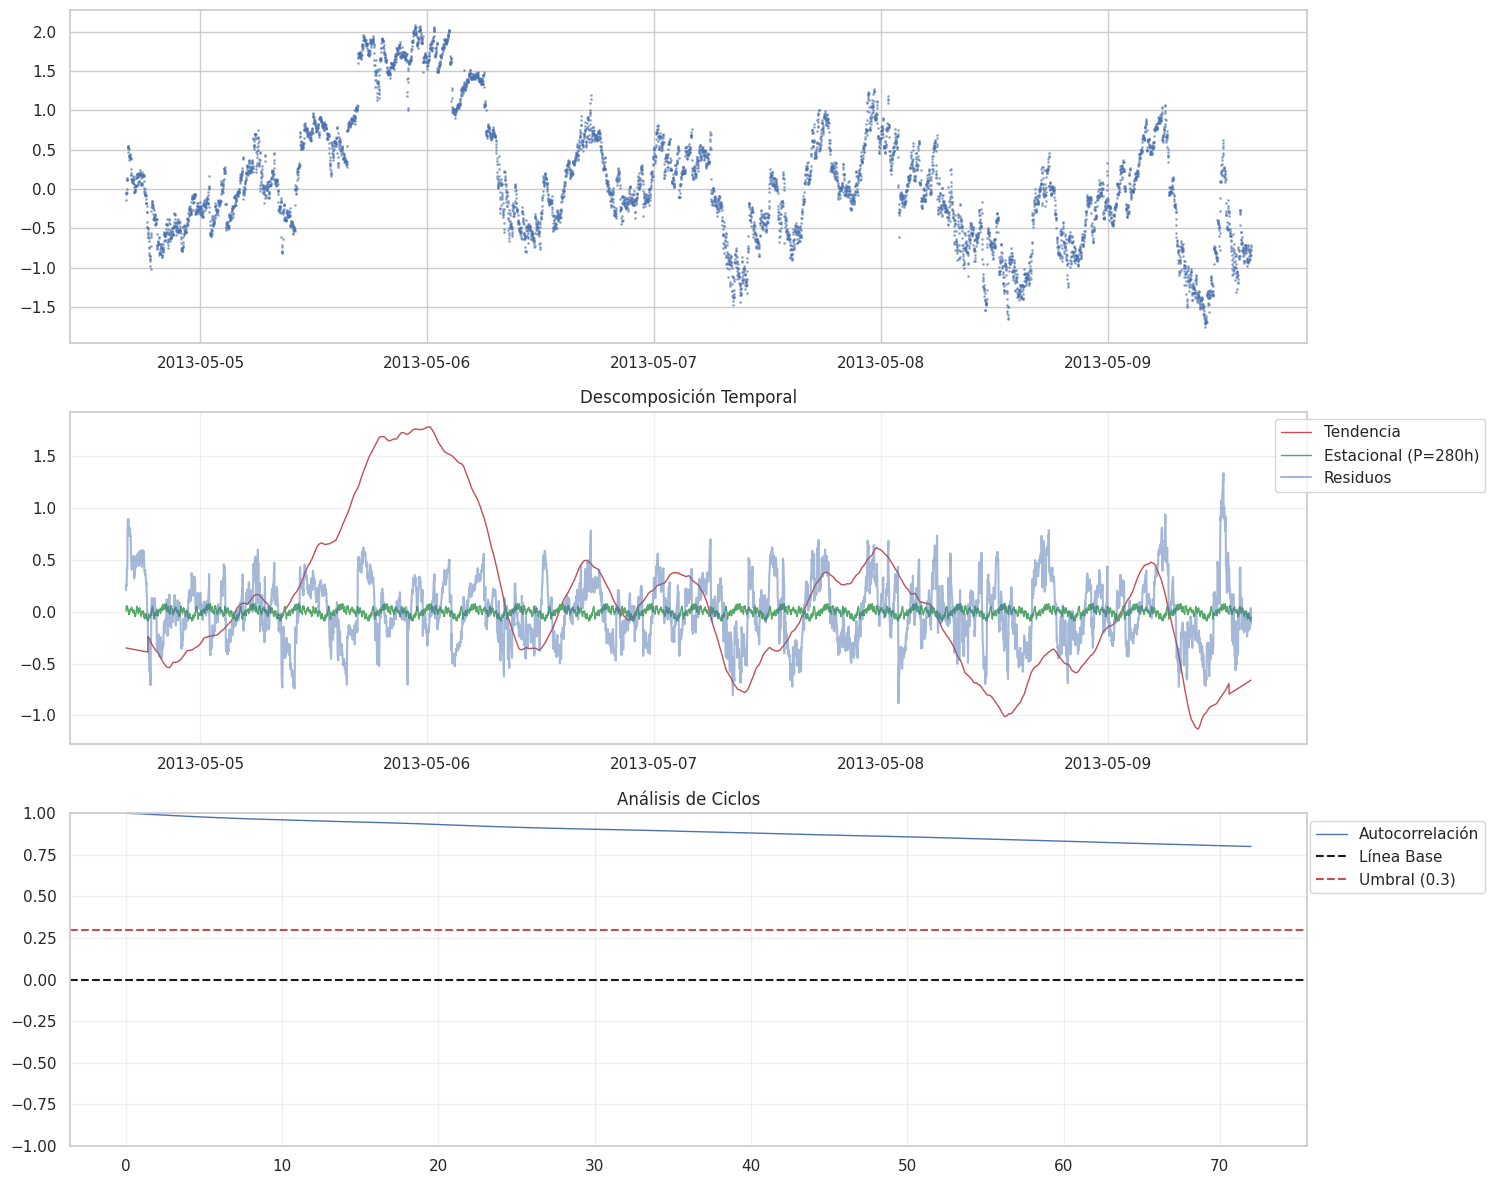


=== RESUMEN DE ANÁLISIS ===

Estadísticas Globales:
mean: 0.087
std: 0.779
median: 0.000
q25: -0.449
q75: 0.551
min: -1.758
max: 2.084
skewness: 0.462
kurtosis: -0.099

Patrones Temporales:
Tendencia: decreasing
Fuerza de tendencia: 0.385
Período estacional: 280
Fuerza estacional: 0.629


In [4]:
# CELDA 4: Fase 3 - Aprendizaje de Línea Base
"""
Fase 3: Aprendizaje de Línea Base
================================

Objetivos:
1. Establecer patrones normales de comportamiento
2. Definir límites adaptativos
3. Identificar ciclos y estacionalidad
4. Crear modelo base para detección de anomalías

Características:
- Análisis temporal robusto
- Límites adaptativos basados en timestamps
- Detección de patrones cíclicos
- Manejo eficiente de memoria
- Integración con fases anteriores
"""

# Importaciones necesarias
from typing import Dict, List, Any, Optional, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from sklearn.preprocessing import RobustScaler
import logging
class BaselineLearner:
    def __init__(self, window_size: int = 168):  # 1 semana por defecto
        """
        Inicializa el aprendizaje de línea base.
        
        Args:
            window_size: Tamaño de ventana para análisis móvil (en períodos)
        """
        self._setup_logging()
        self.window_size = window_size
        self.scaler = RobustScaler()
        self.data = None
        self.results = {
            'baseline_stats': {},
            'adaptive_limits': {},
            'temporal_patterns': {},
            'cycles': {},
            'validation': {}
        }

    def _setup_logging(self):
        """Configura el sistema de logging"""
        self.logger = logging.getLogger(__name__)
        
    def learn_baseline(self, data: pd.DataFrame, selected_vars: List[str] = None,
                      variable_analyzer_results: Dict = None) -> Dict[str, Any]:
        """
        Aprende la línea base del sistema.
        
        Args:
            data: DataFrame con índice temporal
            selected_vars: Lista de variables a analizar (si None, usa todas)
            variable_analyzer_results: Resultados del VariableAnalyzer
            
        Returns:
            Dict con resultados del aprendizaje
        """
        try:
            self.logger.info("Iniciando aprendizaje de línea base...")
            
            # Validar índice temporal
            if not isinstance(data.index, pd.DatetimeIndex):
                self.logger.error("Los datos deben tener un índice temporal")
                return None
            # Guardar los datos
            self.data = data.copy()  # Añadir esta línea
            
            # Seleccionar variables
            if selected_vars is None:
                selected_vars = data.select_dtypes(include=[np.number]).columns
            
            # Integrar resultados del VariableAnalyzer si están disponibles
            if variable_analyzer_results:
                self.results['variable_importance'] = variable_analyzer_results.get('importance_scores', {})
                self.results['correlations'] = variable_analyzer_results.get('correlations', {})
            
            # Procesar cada variable
            for column in selected_vars:
                self.logger.info(f"Analizando variable: {column}")
                
                # Obtener serie temporal limpia
                series = self._prepare_series(data[column])
                if series is None:
                    continue
                
                # Análisis completo
                self._analyze_variable(series, column)
                
                # Validar resultados
                if not self.validate_baseline(column):
                    self.logger.warning(f"Análisis incompleto para {column}")
            
            self.logger.info("Aprendizaje de línea base completado")
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error en aprendizaje: {str(e)}")
            return None

    def _prepare_series(self, series: pd.Series) -> Optional[pd.Series]:
        """Prepara la serie temporal para análisis"""
        try:
            # Eliminar valores infinitos
            series = series.replace([np.inf, -np.inf], np.nan)
            
            # Interpolar valores faltantes preservando temporalidad
            if series.isnull().sum() > 0:
                if series.isnull().sum() / len(series) > 0.3:  # Más de 30% nulos
                    self.logger.warning(f"Demasiados valores nulos en {series.name}")
                    return None
                series = series.interpolate(method='time')
            
            return series
            
        except Exception as e:
            self.logger.error(f"Error en preparación de serie: {str(e)}")
            return None

    def _analyze_variable(self, series: pd.Series, column: str):
        """Realiza análisis completo de una variable"""
        try:
            # 1. Calcular estadísticas base
            self._calculate_baseline_stats(series, column)
            
            # 2. Calcular límites adaptativos
            self._calculate_adaptive_limits(series, column)
            
            # 3. Analizar patrones temporales
            self._analyze_temporal_patterns(series, column)
            
            # 4. Detectar ciclos
            self._detect_cycles(series, column)
            
        except Exception as e:
            self.logger.error(f"Error en análisis de {column}: {str(e)}")

    def _calculate_baseline_stats(self, series: pd.Series, column: str):
        """Calcula estadísticas base de la serie"""
        try:
            # Estadísticas globales
            self.results['baseline_stats'][column] = {
                'global': {
                    'mean': float(series.mean()),
                    'std': float(series.std()),
                    'median': float(series.median()),
                    'q25': float(series.quantile(0.25)),
                    'q75': float(series.quantile(0.75)),
                    'min': float(series.min()),
                    'max': float(series.max()),
                    'skewness': float(series.skew()),
                    'kurtosis': float(series.kurtosis())
                },
                'rolling': {
                    'mean': self._efficient_series_to_dict(
                        series.rolling(window=self.window_size, min_periods=1).mean()
                    ),
                    'std': self._efficient_series_to_dict(
                        series.rolling(window=self.window_size, min_periods=1).std()
                    )
                }
            }
        except Exception as e:
            self.logger.error(f"Error en estadísticas base de {column}: {str(e)}")

    def _calculate_adaptive_limits(self, series: pd.Series, column: str):
        """Calcula límites adaptativos basados en patrones temporales"""
        try:
            # Calcular estadísticas móviles
            rolling_mean = series.rolling(window=self.window_size, min_periods=1).mean()
            rolling_std = series.rolling(window=self.window_size, min_periods=1).std()
            
            # Factor de estacionalidad
            seasonal_factor = self._estimate_seasonal_factor(series)
            
            # Calcular límites
            z_score = 3.0  # 99.7% intervalo de confianza
            
            # Modificación clave: Almacenar valores base
            self.results['adaptive_limits'][column] = {
                'baseline': float(series.mean()),  # Añadir línea base
                'upper': float(series.mean() + (z_score * series.std())),
                'lower': float(series.mean() - (z_score * series.std())),
                'center': float(series.mean()),
                'std_factor': float(z_score),
                # Añadir límites dinámicos
                'dynamic': {
                    'upper': self._efficient_series_to_dict(rolling_mean + (z_score * rolling_std * seasonal_factor)),
                    'lower': self._efficient_series_to_dict(rolling_mean - (z_score * rolling_std * seasonal_factor)),
                    'center': self._efficient_series_to_dict(rolling_mean)
                }
            }
            
        except Exception as e:
            self.logger.error(f"Error en límites adaptativos de {column}: {str(e)}")
            
    def _analyze_temporal_patterns(self, series: pd.Series, column: str):
        """Analiza patrones temporales en la serie"""
        try:
            # Análisis de tendencia
            trend_analysis = self._analyze_trend(series)
            
            # Análisis de estacionalidad
            seasonality_analysis = self._analyze_seasonality(series)
            
            # Análisis de volatilidad
            volatility = self._analyze_volatility(series)
            
            self.results['temporal_patterns'][column] = {
                'trend': trend_analysis,
                'seasonality': seasonality_analysis,
                'volatility': volatility
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis temporal de {column}: {str(e)}")

    def _detect_cycles(self, series: pd.Series, column: str):
        """Detecta ciclos significativos en la serie"""
        try:
            # Calcular autocorrelación
            n_lags = min(len(series) - 1, self.window_size * 3)
            acf_values = acf(series.fillna(method='ffill'), nlags=n_lags)
            
            # Detectar picos significativos
            peaks = []
            for lag in range(1, len(acf_values)):
                if (acf_values[lag] > acf_values[lag-1] and 
                    (lag == len(acf_values)-1 or acf_values[lag] > acf_values[lag+1]) and
                    acf_values[lag] > 0.3):  # Umbral de significancia
                    peaks.append({
                        'lag': int(lag),
                        'strength': float(acf_values[lag])
                    })
            
            # Ordenar por fuerza
            peaks.sort(key=lambda x: x['strength'], reverse=True)
            
            self.results['cycles'][column] = {
                'main_cycles': peaks[:3],  # Top 3 ciclos
                'total_cycles': len(peaks)
            }
            
        except Exception as e:
            self.logger.error(f"Error en detección de ciclos de {column}: {str(e)}")

    def _efficient_series_to_dict(self, series: pd.Series) -> Dict[str, float]:
        """Convierte serie temporal a diccionario eficiente"""
        return {str(idx): float(val) 
                for idx, val in series.items() 
                if not (np.isnan(val) or np.isinf(val))}

    def _estimate_seasonal_factor(self, series: pd.Series) -> Union[float, pd.Series]:
        """Estima el factor de estacionalidad"""
        try:
            period = self._detect_seasonality_period(series)
            if period > 1:
                decomposition = seasonal_decompose(
                    series.fillna(method='ffill'),
                    period=period
                )
                seasonal = decomposition.seasonal
                return 1 + (seasonal - seasonal.mean()) / seasonal.std()
            return 1.0
        except Exception as e:
            self.logger.error(f"Error en factor estacional: {str(e)}")
            return 1.0

    def _detect_seasonality_period(self, series: pd.Series) -> int:
        """Detecta el período de estacionalidad"""
        try:
            n_lags = min(len(series)-1, 365)
            acf_values = acf(series.fillna(method='ffill'), nlags=n_lags)
            
            peaks = [i for i in range(1, len(acf_values)-1) 
                    if acf_values[i] > acf_values[i-1] and 
                    acf_values[i] > acf_values[i+1] and 
                    acf_values[i] > 0.3]
            
            return peaks[0] if peaks else 1
            
        except Exception as e:
            self.logger.error(f"Error en detección de estacionalidad: {str(e)}")
            return 1

    def _analyze_trend(self, series: pd.Series) -> Dict[str, Any]:
        """Analiza la tendencia de la serie"""
        try:
            # Regresión lineal sobre tiempo
            time_numeric = np.arange(len(series))
            slope, _, r_value, p_value, _ = stats.linregress(
                time_numeric, 
                series.fillna(method='ffill')
            )
            
            return {
                'direction': 'increasing' if slope > 0 else 'decreasing',
                'strength': abs(r_value),
                'significance': float(p_value) < 0.05,
                'slope': float(slope)
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis de tendencia: {str(e)}")
            return {}

    def _analyze_seasonality(self, series: pd.Series) -> Dict[str, Any]:
        """Analiza la estacionalidad de la serie"""
        try:
            period = self._detect_seasonality_period(series)
            
            if period > 1:
                decomposition = seasonal_decompose(
                    series.fillna(method='ffill'),
                    period=period
                )
                
                strength = 1 - (decomposition.resid.std() / series.std())
                return {
                    'period': int(period),
                    'strength': float(strength),
                    'significant': strength > 0.3
                }
            
            return {
                'period': 1,
                'strength': 0.0,
                'significant': False
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis de estacionalidad: {str(e)}")
            return {}

    def _analyze_volatility(self, series: pd.Series) -> Dict[str, Any]:
        """Analiza la volatilidad de la serie"""
        try:
            changes = series.pct_change().dropna()
            return {
                'std_dev': float(changes.std()),
                'mean_abs_change': float(changes.abs().mean()),
                'volatility_index': float(changes.std() / series.mean())
            }
        except Exception as e:
            self.logger.error(f"Error en análisis de volatilidad: {str(e)}")
            return {}
    def visualize_baseline(self, column: str):
        """Visualiza la línea base y patrones temporales"""
        try:
            if column not in self.data.columns:
                self.logger.error(f"Variable {column} no encontrada")
                return
                    
            fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
            
            # 1. Serie temporal y límites adaptativos (mantener como está)
            series = self.data[column].copy()
            series = series.fillna(method='ffill').fillna(method='bfill')
            ax1.plot(series.index, series.values, 'b.', label='Datos originales', alpha=0.5, markersize=2)
            
            # ... (código existente de límites adaptativos) ...
                # 2. CAMBIO: Mejorar la descomposición temporal
            ax2.set_title('Descomposición Temporal')
            if column in self.results['temporal_patterns']:
                patterns = self.results['temporal_patterns'][column]
                # Usar período mínimo si no hay estacionalidad detectada
                period = max(
                    patterns.get('seasonality', {}).get('period', 24),
                    24  # período mínimo
                )
                
                try:
                    # Preparar serie para descomposición
                    clean_series = series.fillna(method='ffill').fillna(method='bfill')
                    decomposition = seasonal_decompose(
                        clean_series,
                        period=period,
                        extrapolate_trend='freq'  # Mejor manejo de tendencias
                    )
                    
                    # Asegurar alineación temporal
                    trend = pd.Series(decomposition.trend, index=series.index)
                    seasonal = pd.Series(decomposition.seasonal, index=series.index)
                    resid = pd.Series(decomposition.resid, index=series.index)
                    
                    # Plotear componentes
                    ax2.plot(series.index, trend, 'r-', label='Tendencia', linewidth=1)
                    ax2.plot(series.index, seasonal, 'g-', 
                            label=f'Estacional (P={period}h)', linewidth=1)
                    ax2.plot(series.index, resid, 'b-', label='Residuos', alpha=0.5)
                    
                except Exception as e:
                    self.logger.warning(f"Error en descomposición de {column}: {str(e)}")
                    # Mostrar al menos la serie original en caso de error
                    ax2.plot(series.index, series.values, 'b-', label='Serie Original')
            
            ax2.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
            ax2.grid(True, alpha=0.3)
            
            # 3. CAMBIO: Mejorar análisis de ciclos
            ax3.set_title('Análisis de Ciclos')
            try:
                # Siempre calcular ACF
                clean_series = series.fillna(method='ffill').fillna(method='bfill')
                n_lags = min(len(clean_series) - 1, self.window_size * 3)
                acf_values = acf(clean_series, nlags=n_lags, fft=True)  # Usar FFT para mejor rendimiento
                lags = np.arange(len(acf_values))
                
                # Plotear ACF base
                ax3.plot(lags, acf_values, 'b-', label='Autocorrelación', linewidth=1)
                ax3.axhline(y=0, color='k', linestyle='--', label='Línea Base')
                ax3.axhline(y=0.3, color='r', linestyle='--', label='Umbral (0.3)')
                
                # Agregar ciclos si existen
                if column in self.results['cycles']:
                    cycles = self.results['cycles'][column].get('main_cycles', [])
                    for cycle in cycles:
                        ax3.plot(cycle['lag'], cycle['strength'], 'ro')
                        ax3.annotate(
                            f"P={cycle['lag']}h\n(r={cycle['strength']:.2f})",
                            (cycle['lag'], cycle['strength']),
                            xytext=(5, 5), textcoords='offset points',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
                        )
                
            except Exception as e:
                self.logger.warning(f"Error en análisis de ciclos de {column}: {str(e)}")
            
            ax3.set_ylim(-1, 1)
            ax3.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
            ax3.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            # Imprimir resumen
            self._print_analysis_summary(column)
                
        except Exception as e:
            self.logger.error(f"Error en visualización de {column}: {str(e)}")
                

    def validate_baseline(self, column: str) -> bool:
        """Valida la calidad del aprendizaje de línea base"""
        try:
            if column not in self.results['baseline_stats']:
                return False
                
            # Verificar completitud de resultados
            required_analyses = [
                'baseline_stats',
                'adaptive_limits',
                'temporal_patterns',
                'cycles'
            ]
            
            for analysis in required_analyses:
                if column not in self.results[analysis]:
                    self.logger.warning(f"Falta análisis {analysis} para {column}")
                    return False
            
            # Verificar calidad de límites adaptativos
            limits = self.results['adaptive_limits'][column]
            if not (limits['upper'] and limits['lower']):
                self.logger.warning(f"Límites adaptativos incompletos para {column}")
                return False
            
            # Verificar calidad de patrones temporales
            patterns = self.results['temporal_patterns'][column]
            if not all(k in patterns for k in ['trend', 'seasonality', 'volatility']):
                self.logger.warning(f"Patrones temporales incompletos para {column}")
                return False
                
            return True
            
        except Exception as e:
            self.logger.error(f"Error en validación de {column}: {str(e)}")
            return False

    def _print_analysis_summary(self, column: str):
        """Imprime resumen del análisis"""
        try:
            print("\n=== RESUMEN DE ANÁLISIS ===")
            
            # Estadísticas globales
            stats = self.results['baseline_stats'][column]['global']
            print("\nEstadísticas Globales:")
            for k, v in stats.items():
                print(f"{k}: {v:.3f}")
            
            # Patrones temporales
            if column in self.results['temporal_patterns']:
                patterns = self.results['temporal_patterns'][column]
                print("\nPatrones Temporales:")
                print(f"Tendencia: {patterns['trend']['direction']}")
                print(f"Fuerza de tendencia: {patterns['trend']['strength']:.3f}")
                print(f"Período estacional: {patterns['seasonality']['period']}")
                print(f"Fuerza estacional: {patterns['seasonality']['strength']:.3f}")
            
            # Ciclos principales
            if column in self.results['cycles']:
                cycles = self.results['cycles'][column]['main_cycles']
                if cycles:
                    print("\nCiclos Principales:")
                    for cycle in cycles:
                        print(f"Período: {cycle['lag']}, Fuerza: {cycle['strength']:.3f}")
            
        except Exception as e:
            self.logger.error(f"Error en resumen de {column}: {str(e)}")

# Función de prueba
def test_baseline_learning(data: pd.DataFrame, variable_analyzer_results: Dict = None):
    """Prueba el aprendizaje de línea base"""
    try:
        print("\n=== PRUEBA DE APRENDIZAJE DE LÍNEA BASE ===\n")
        
        # Crear instancia
        learner = BaselineLearner(window_size=24)
        
        # Selección automática de variables críticas
        if variable_analyzer_results:
            # Obtener todas las variables críticas (top 20% del análisis previo)
            critical_vars = [
                var for var, info in variable_analyzer_results.get('categories', {}).get('critical', {}).items()
            ]
            
            # Si no hay suficientes variables críticas, incluir las de monitoreo más importantes
            if len(critical_vars) < 3:  # Asegurar un mínimo de variables
                monitoring_vars = [
                    var for var, info in variable_analyzer_results.get('categories', {}).get('monitoring', {}).items()
                ]
                selected_vars = critical_vars + monitoring_vars
            else:
                selected_vars = critical_vars
                
            print(f"\nAnalizando {len(selected_vars)} variables principales:")
            for var in selected_vars:
                print(f"- {var}")
        else:
            selected_vars = None
            print("\nNo hay resultados previos de análisis. Analizando todas las variables numéricas.")
        
        # Aprender línea base
        results = learner.learn_baseline(data, selected_vars, variable_analyzer_results)
        
        if results:
            print("\nVariables analizadas:")
            for column in results['baseline_stats'].keys():
                print(f"\nAnalizando {column}:")
                learner.visualize_baseline(column)
            return learner
        else:
            print("Error en aprendizaje de línea base")
            return None
            
    except Exception as e:
        print(f"Error en prueba: {str(e)}")
        return None
    
if 'processed_data' in globals() and 'variable_analysis_results' in globals():
    print("\nIniciando prueba de aprendizaje de línea base...")
    baseline_learner = test_baseline_learning(processed_data, variable_analysis_results)
else:
    print("Error: Ejecutar primero el preprocesamiento de datos y análisis de variables")

2024-12-24 10:47:59,189 - INFO - Iniciando predicción de fallas industriales...



Iniciando sistema de predicción de fallas...
Estado del baseline_learner: <class '__main__.BaselineLearner'>
Resultados disponibles: ['baseline_stats', 'adaptive_limits', 'temporal_patterns', 'cycles', 'validation', 'variable_importance', 'correlations']

=== PRUEBA DE SISTEMA DE PREDICCIÓN DE FALLAS INDUSTRIAL ===

Variables disponibles para análisis: 12


2024-12-24 10:48:01,335 - INFO - Procesando predicciones para 12 variables
2024-12-24 10:48:01,386 - INFO - 
                Integración completada:
                - Variables procesadas: 12
                - Prob. Sistema Actual: 1.0%
                - Prob. Sistema 24h: 1.0%
            



Resultados de la predicción:
- Probabilidad actual del sistema: 1.0%


2024-12-24 10:48:01,681 - INFO - Visualización generada exitosamente


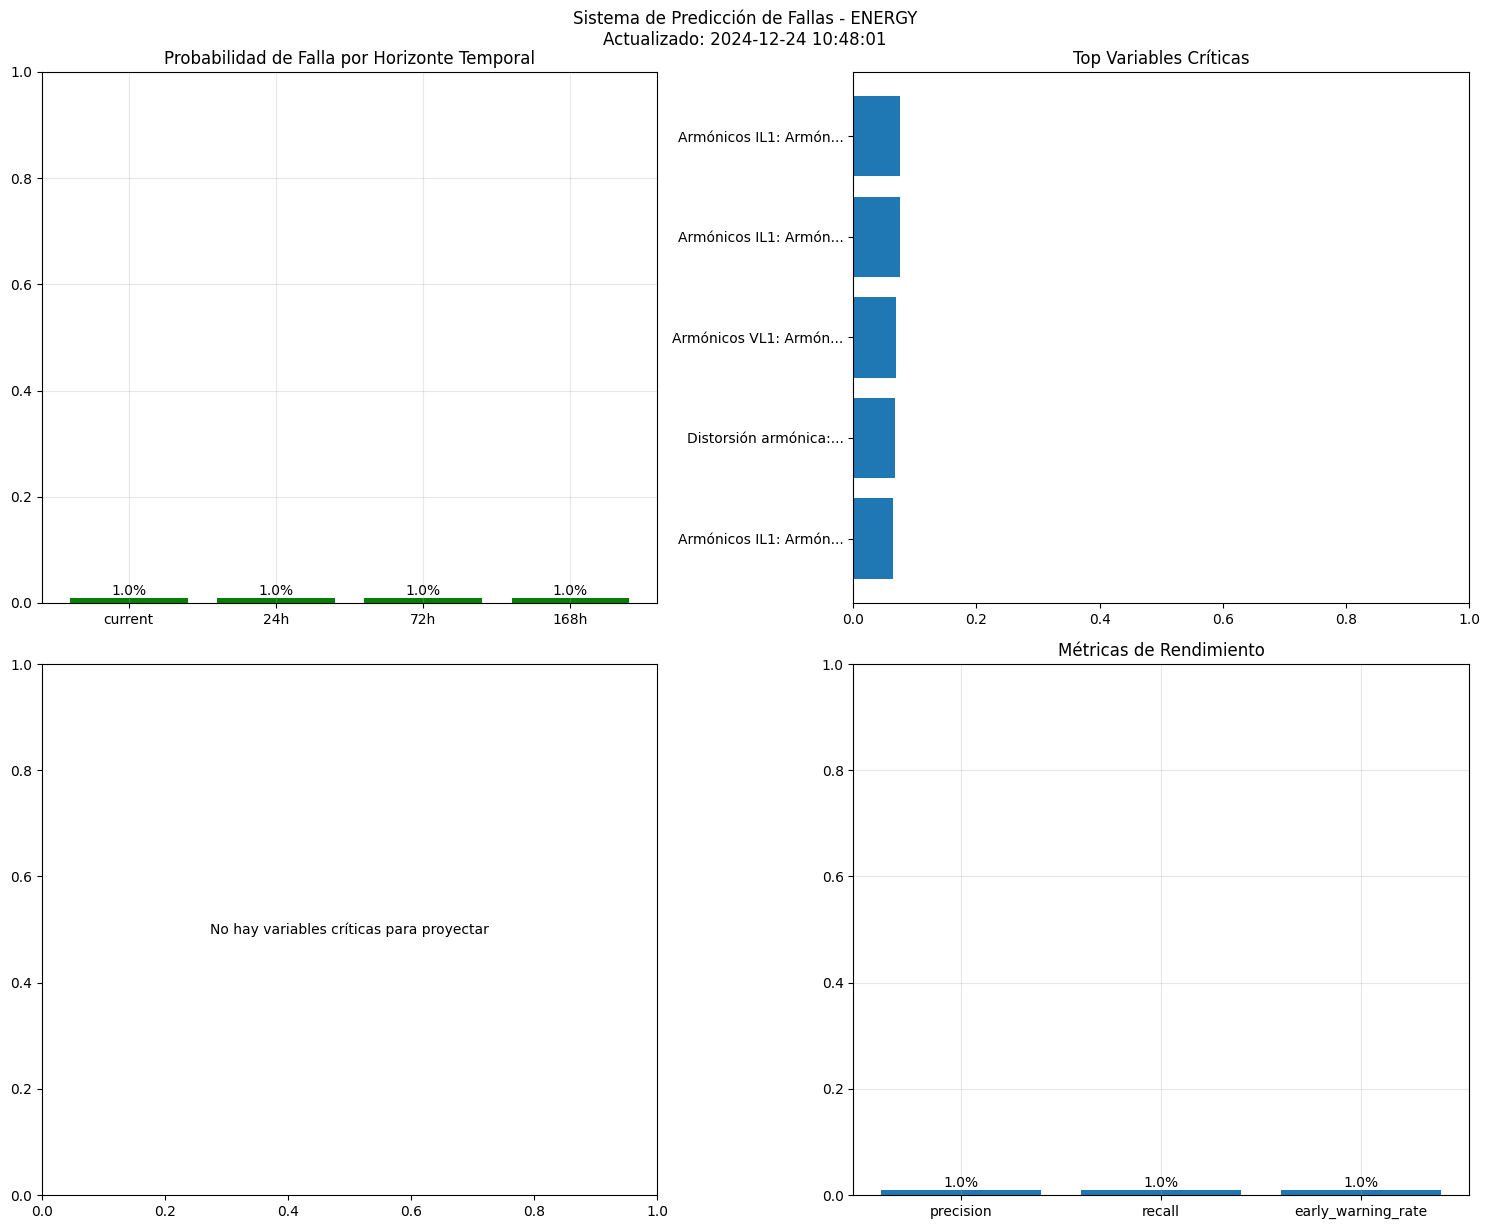

In [5]:
# CELDA 5: Fase 4 - Sistema de Predicción de Fallas Industrial
"""
Sistema de Predicción de Fallas Industrial
========================================

Principios Fundamentales:
1. Detección de anomalías (comparación con línea base)
2. Análisis de tendencias (variaciones temporales)
3. Evaluación de límites (alertas críticas)

Características:
- Predicción de fallas basada en múltiples factores
- Análisis temporal multinivel
- Sistema de alertas tempranas
- Prognosis industrial avanzada
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
from scipy import stats
from typing import Dict, List, Any, Tuple, Optional
import logging
import time
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Configuración de visualización y logging
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class IndustrialFailurePredictor:
    """
    Sistema de predicción de fallas industriales basado en los tres principios fundamentales.
    """
    def __init__(self, baseline: BaselineLearner, 
                 system_type: str = 'energy',
                 thresholds: Dict[str, float] = None):
        """
        Inicializa el predictor de fallas industrial.
        
        Args:
            baseline: Objeto BaselineLearner con la línea base aprendida
            system_type: Tipo de sistema ('energy', 'reliability', 'quality')
            thresholds: Diccionario de umbrales para detección
        """
        self.baseline = baseline
        self.system_type = system_type
        self.thresholds = self._get_system_thresholds(thresholds)

        if not self.validate_baseline_integration():
            raise ValueError("Baseline learner no tiene todos los componentes necesarios")
        
        # Métricas de rendimiento industrial
        self.kpis = {
            'precision': 0.0,
            'recall': 0.0,
            'false_positive_rate': 0.0,
            'response_time': 0.0,
            'early_warning_rate': 0.0,
            'mttf': 0.0,  # Mean Time To Failure
            'mttr': 0.0   # Mean Time To Repair
        }
        
        # Resultados por principio fundamental
        self.results = {
            'anomaly_detection': {
                'deviations': {},      # Desviaciones de línea base
                'patterns': {},        # Patrones anómalos
                'context': {}          # Contexto de anomalías
            },
            'trend_analysis': {
                'short_term': {},      # Tendencias 24h
                'medium_term': {},     # Tendencias 72h
                'long_term': {},       # Tendencias 168h
                'projections': {}      # Proyecciones futuras
            },
            'limit_evaluation': {
                'violations': {},      # Violaciones de límites
                'adaptive_limits': {}, # Límites actualizados
                'alerts': {}           # Sistema de alertas
            },
            'failure_probability': {
                'current': None,       # Probabilidad actual
                'forecast': {          # Pronóstico
                    '24h': None,
                    '72h': None,
                    '168h': None
                }
            },
            'system_health': {
                'current_state': {},
                'predictions': {},
                'reliability_metrics': {}
            }
        }
        
        self._setup_logging()
        self._initialize_monitoring()

    def validate_baseline_integration(self) -> bool:
        """Valida la integración con BaselineLearner"""
        try:
            required_results = [
                'baseline_stats',
                'adaptive_limits',
                'temporal_patterns',
                'cycles'
            ]
            
            for result in required_results:
                if result not in self.baseline.results:
                    self.logger.error(f"Falta {result} en baseline")
                    return False
            return True
            
        except Exception as e:
            self.logger.error(f"Error en validación: {str(e)}")
            return False
    
    def _calculate_projection_factor(self, projection: Dict, limits: Dict) -> float:
        """
        Calcula el factor de proyección basado en límites adaptativos.
        
        Args:
            projection: Diccionario con datos de proyección
            limits: Diccionario con límites adaptativos
        
        Returns:
            float: Factor de ajuste entre 0.8 y 1.2
        """
        try:
            # Validar entrada
            if not isinstance(projection, dict) or not isinstance(limits, dict):
                return 1.0
                
            # Obtener valores base
            projected_value = projection.get('value', 0.0)
            baseline = limits.get('baseline', 0.0)
            upper_limit = limits.get('upper', baseline * 1.2)
            lower_limit = limits.get('lower', baseline * 0.8)
            
            # Calcular distancia a límites
            range_size = max(upper_limit - lower_limit, 1e-10)
            distance_to_baseline = abs(projected_value - baseline)
            normalized_distance = min(1.0, distance_to_baseline / range_size)
            
            # Calcular factor de ajuste
            if projected_value > baseline:
                factor = 1.0 + (0.2 * normalized_distance)  # Máximo 1.2
            else:
                factor = 1.0 - (0.2 * normalized_distance)  # Mínimo 0.8
                
            return float(factor)
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de factor de proyección: {str(e)}")
            return 1.0  # Valor neutral en caso de error
            
    def _get_system_thresholds(self, custom_thresholds=None):
        """Define umbrales específicos por tipo de sistema industrial"""
        base_thresholds = {
            'energy': {
                'critical': 0.9,
                'warning': 0.7,
                'attention': 0.5,
                'trend_significance': 0.05,
                'min_persistence': 3,
                'correlation': 0.7,
                'degradation_rate': 0.1
            },
            'reliability': {
                'critical': 0.85,
                'warning': 0.65,
                'attention': 0.45,
                'trend_significance': 0.1,
                'min_persistence': 4,
                'correlation': 0.75,
                'degradation_rate': 0.15
            },
            'quality': {
                'critical': 0.95,
                'warning': 0.75,
                'attention': 0.55,
                'trend_significance': 0.03,
                'min_persistence': 2,
                'correlation': 0.8,
                'degradation_rate': 0.08
            }
        }
        
        system_thresholds = base_thresholds[self.system_type]
        if custom_thresholds:
            system_thresholds.update(custom_thresholds)
            
        return system_thresholds

    def _setup_logging(self):
        """Configura el sistema de logging industrial"""
        self.logger = logging.getLogger(__name__)
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - [%(system_type)s] %(message)s'
        )
        
        logger_adapter = logging.LoggerAdapter(
            self.logger,
            {'system_type': self.system_type}
        )
        self.logger = logger_adapter

    def _initialize_monitoring(self):
        """Inicializa el sistema de monitoreo industrial"""
        self.monitoring = {
            'start_time': pd.Timestamp.now(),
            'last_update': None,
            'processing_times': [],
            'error_count': 0,
            'warning_count': 0,
            'system_status': 'initializing',
            'last_predictions': {},
            'prediction_accuracy': {}
        }

    def predict_failures(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Método principal para predicción de fallas industriales.
        Implementa los tres principios fundamentales.
        """
        try:
            start_time = time.time()
            self.logger.info("Iniciando predicción de fallas industriales...")
            
            # 1. Detección de Anomalías
            anomalies = self._detect_anomalies(data)
            if anomalies is None:
                return None
                
            # 2. Análisis de Tendencias
            trends = self._analyze_trends(data)
            if trends is None:
                return None
                
            # 3. Evaluación de Límites
            limit_violations = self._evaluate_limits(data)
            if limit_violations is None:
                return None
            
            # Integración de los tres principios para predicción
            failure_probabilities = self._integrate_predictions(
                anomalies,
                trends,
                limit_violations
            )
            
            # Actualizar resultados
            self.results['failure_probability'] = failure_probabilities
            
            # Actualizar KPIs
            self._update_system_kpis(time.time() - start_time)
            
            return self.results
            
        except Exception as e:
            self.logger.error(f"Error crítico en predicción: {str(e)}")
            self.monitoring['error_count'] += 1
            return None

    def _detect_anomalies(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Primer Principio: Detección de Anomalías
        Compara datos actuales con línea base aprendida
        """
        try:
            anomalies_result = {
                'deviations': {},
                'patterns': {},
                'context': {}
            }
            
            for column in data.select_dtypes(include=[np.number]).columns:
                if column in self.baseline.results['adaptive_limits']:
                    # Calcular desviaciones
                    deviations = self._calculate_deviations(
                        data[column],
                        self.baseline.results['adaptive_limits'][column]
                    )
                    
                    # Identificar patrones anómalos
                    patterns = self._identify_anomaly_patterns(
                        deviations,
                        self.thresholds
                    )
                    
                    # Analizar contexto
                    context = self._analyze_anomaly_context(
                        data[column],
                        deviations,
                        patterns
                    )
                    
                    # Almacenar resultados
                    anomalies_result['deviations'][column] = deviations
                    anomalies_result['patterns'][column] = patterns
                    anomalies_result['context'][column] = context
            
            self.results['anomaly_detection'] = anomalies_result
            return anomalies_result
            
        except Exception as e:
            self.logger.error(f"Error en detección de anomalías: {str(e)}")
            return None

    def _analyze_trends(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Segundo Principio: Análisis de Tendencias
        Evalúa cambios temporales y proyecta tendencias
        """
        try:
            trends_result = {
                'short_term': {},
                'medium_term': {},
                'long_term': {},
                'projections': {}
            }
            
            for column in data.select_dtypes(include=[np.number]).columns:
                if column in self.baseline.results['adaptive_limits']:
                    # Análisis por ventana temporal
                    for window_type in ['short_term', 'medium_term', 'long_term']:
                        window_size = self._get_window_size(window_type)
                        trend_analysis = self._analyze_window_trend(
                            data[column],
                            window_size
                        )
                        trends_result[window_type][column] = trend_analysis
                    
                    # Proyección de tendencias
                    projections = self._project_trends(
                        data[column],
                        trends_result
                    )
                    trends_result['projections'][column] = projections
            
            self.results['trend_analysis'] = trends_result
            return trends_result
            
        except Exception as e:
            self.logger.error(f"Error en análisis de tendencias: {str(e)}")
            return None

    def _evaluate_limits(self, data: pd.DataFrame) -> Dict[str, Any]:
        """
        Tercer Principio: Evaluación de Límites
        Monitorea violaciones y actualiza límites adaptativos
        """
        try:
            limits_result = {
                'violations': {},
                'adaptive_limits': {},
                'alerts': {}
            }
            
            for column in data.select_dtypes(include=[np.number]).columns:
                if column in self.baseline.results['adaptive_limits']:
                    # Evaluar violaciones
                    violations = self._check_limit_violations(
                        data[column],
                        self.baseline.results['adaptive_limits'][column]
                    )
                    
                    # Actualizar límites adaptativos
                    new_limits = self._update_adaptive_limits(
                        data[column],
                        violations
                    )
                    
                    # Generar alertas
                    alerts = self._generate_alerts(
                        violations,
                        self.results['trend_analysis'],
                        column
                    )
                    
                    # Almacenar resultados
                    limits_result['violations'][column] = violations
                    limits_result['adaptive_limits'][column] = new_limits
                    limits_result['alerts'][column] = alerts
            
            self.results['limit_evaluation'] = limits_result
            return limits_result
            
        except Exception as e:
            self.logger.error(f"Error en evaluación de límites: {str(e)}")
            return None
        
    def _identify_critical_variables(self) -> Dict[str, Dict[str, Any]]:
        """
        Identifica y analiza las variables críticas del sistema basándose en múltiples factores.
        
        Returns:
            Dict[str, Dict[str, Any]]: Diccionario con variables críticas y sus métricas
        """
        try:
            critical_vars = {}
            
            # 1. Obtener todas las variables monitoreadas
            monitored_vars = set(self.baseline.results['baseline_stats'].keys())
            
            for var in monitored_vars:
                var_metrics = {
                    'anomaly_score': 0.0,
                    'trend_score': 0.0,
                    'violation_score': 0.0,
                    'importance_score': 0.0,
                    'total_score': 0.0,
                    'status': 'normal'
                }
                
                # 2. Calcular score de anomalías (35%)
                if var in self.results['anomaly_detection']['deviations']:
                    deviations = self.results['anomaly_detection']['deviations'][var]
                    recent_scores = [
                        dev['score'] for dev in deviations.values()
                        if isinstance(dev, dict) and 'score' in dev
                    ]
                    if recent_scores:
                        # Dar más peso a anomalías recientes
                        weights = np.exp(np.linspace(0, 1, len(recent_scores)))
                        var_metrics['anomaly_score'] = float(np.average(recent_scores, weights=weights))
                
                # 3. Calcular score de tendencia (35%)
                if var in self.results['trend_analysis']['short_term']:
                    trend = self.results['trend_analysis']['short_term'][var]
                    if trend and 'slope' in trend and 'confidence' in trend:
                        trend_magnitude = abs(float(trend['slope']))
                        trend_confidence = float(trend['confidence'])
                        var_metrics['trend_score'] = trend_magnitude * trend_confidence
                
                # 4. Calcular score de violaciones (30%)
                if var in self.results['limit_evaluation']['violations']:
                    violations = self.results['limit_evaluation']['violations'][var]
                    if violations:
                        recent_violations = [
                            v for v in violations.values()
                            if isinstance(v, dict) and v.get('is_violation', False)
                        ]
                        if recent_violations:
                            violation_rate = len(recent_violations) / len(violations)
                            violation_severity = np.mean([
                                v.get('severity', 0) for v in recent_violations
                            ])
                            var_metrics['violation_score'] = violation_rate * violation_severity
                
                # 5. Calcular importancia de la variable
                var_metrics['importance_score'] = self._calculate_variable_importance(var)
                
                # 6. Calcular score total ponderado
                var_metrics['total_score'] = (
                    0.35 * var_metrics['anomaly_score'] +
                    0.35 * var_metrics['trend_score'] +
                    0.30 * var_metrics['violation_score']
                ) * var_metrics['importance_score']
                
                # 7. Determinar estado de la variable
                if var_metrics['total_score'] >= 0.7:
                    var_metrics['status'] = 'critical'
                elif var_metrics['total_score'] >= 0.4:
                    var_metrics['status'] = 'warning'
                else:
                    var_metrics['status'] = 'normal'
                
                # 8. Incluir si es relevante (score > 0.2)
                if var_metrics['total_score'] > 0.2:
                    critical_vars[var] = var_metrics
            
            # 9. Ordenar por score total
            critical_vars = dict(sorted(
                critical_vars.items(),
                key=lambda x: x[1]['total_score'],
                reverse=True
            ))
            
            # 10. Logging de variables críticas
            self.logger.info(f"Variables críticas identificadas: {len(critical_vars)}")
            for var, metrics in critical_vars.items():
                self.logger.debug(f"""
                    Variable: {var}
                    - Score Total: {metrics['total_score']:.3f}
                    - Estado: {metrics['status']}
                    - Anomalías: {metrics['anomaly_score']:.3f}
                    - Tendencia: {metrics['trend_score']:.3f}
                    - Violaciones: {metrics['violation_score']:.3f}
                """)
            
            return critical_vars
            
        except Exception as e:
            self.logger.error(f"Error en identificación de variables críticas: {str(e)}")
            return {}
        
    def _integrate_predictions(self, anomalies: Dict, trends: Dict, limits: Dict) -> Dict[str, Any]:
        """
        Integra los resultados de los tres principios fundamentales.
        
        Args:
            anomalies: Resultados de detección de anomalías
            trends: Resultados de análisis de tendencias
            limits: Resultados de evaluación de límites
        
        Returns:
            Dict con probabilidades actuales y pronósticos
        """
        try:
            failure_probs = {
                'current': {},
                'forecast': {
                    '24h': {},
                    '72h': {},
                    '168h': {}
                }
            }
            
            # 1. Validación de entrada
            if not all([isinstance(x, dict) for x in [anomalies, trends, limits]]):
                raise ValueError("Entradas inválidas para integración")
                
            # 2. Logging inicial
            self.logger.info(f"Procesando predicciones para {len(anomalies.get('deviations', {}))} variables")
            
            # 3. Procesar cada variable
            for column in anomalies.get('deviations', {}).keys():
                # 3.1 Calcular probabilidad actual
                current_prob = self._calculate_current_probability(
                    anomalies['deviations'].get(column, {}),
                    trends['short_term'].get(column, {}),
                    limits['violations'].get(column, {})
                )
                
                failure_probs['current'][column] = current_prob
                
                # 3.2 Calcular pronósticos
                forecasts = self._calculate_failure_forecasts(
                    column,
                    current_prob,
                    trends['projections'].get(column, {}),
                    limits['adaptive_limits'].get(column, {})
                )
                
                # 3.3 Almacenar pronósticos
                for horizon in ['24h', '72h', '168h']:
                    failure_probs['forecast'][horizon][column] = \
                        max(0.01, forecasts.get(horizon, current_prob))
            
            # 4. Calcular probabilidades del sistema
            if failure_probs['current']:
                # 4.1 Probabilidad actual del sistema
                system_prob = self._calculate_system_probability(failure_probs['current'])
                failure_probs['current']['system'] = max(0.01, system_prob)
                
                # 4.2 Pronósticos del sistema
                for horizon in ['24h', '72h', '168h']:
                    system_forecast = self._calculate_system_probability(
                        failure_probs['forecast'][horizon]
                    )
                    failure_probs['forecast'][horizon]['system'] = max(0.01, system_forecast)
            
            # 5. Logging de resultados
            self.logger.info(f"""
                Integración completada:
                - Variables procesadas: {len(failure_probs['current'])-1}
                - Prob. Sistema Actual: {failure_probs['current'].get('system', 0)*100:.1f}%
                - Prob. Sistema 24h: {failure_probs['forecast']['24h'].get('system', 0)*100:.1f}%
            """)
            
            return failure_probs
            
        except Exception as e:
            self.logger.error(f"Error en integración de predicciones: {str(e)}")
            return None
    
    def _calculate_current_probability(self, deviations: Dict, trend: Dict, violations: Dict) -> float:
        """
        Calcula la probabilidad actual de falla para una variable específica.
        
        Args:
            deviations: Diccionario de desviaciones detectadas
            trend: Diccionario con análisis de tendencias
            violations: Diccionario de violaciones de límites
        
        Returns:
            float: Probabilidad de falla entre 0.01 y 1.0
        """
        try:
            # 1. Logging detallado de entrada
            self.logger.debug(f"""
                Entrada de cálculo de probabilidad:
                Deviations: {len(deviations) if deviations else 0} registros
                Trend data: {trend.keys() if trend else 'None'}
                Violations: {len(violations) if violations else 0} registros
            """)
            
            # 2. Validación estricta de entrada
            if not all([isinstance(deviations, dict), 
                        isinstance(trend, dict), 
                        isinstance(violations, dict)]):
                self.logger.error(f"Tipos de entrada inválidos: dev={type(deviations)}, trend={type(trend)}, viol={type(violations)}")
                return 0.01
                # 3. Factor de Anomalías (40%)
            anomaly_scores = []
            for dev in deviations.values():
                if isinstance(dev, dict) and 'score' in dev:
                    score = float(dev['score'])
                    if 0 <= score <= 1:
                        anomaly_scores.append(score)
            
            anomaly_factor = np.mean(anomaly_scores) if anomaly_scores else 0.01
            
            # 4. Factor de Tendencia (30%)
            trend_factor = 0.01
            if trend and 'slope' in trend and 'confidence' in trend:
                slope = abs(float(trend['slope']))
                confidence = float(trend['confidence'])
                trend_factor = min(1.0, slope * confidence)
            
            # 5. Factor de Violaciones (30%)
            violation_count = sum(1 for v in violations.values() 
                                if isinstance(v, dict) and v.get('is_violation', False))
            violation_severity = np.mean([float(v.get('severity', 0)) 
                                        for v in violations.values() 
                                        if isinstance(v, dict) and v.get('is_violation', False)]) \
                                if violation_count > 0 else 0.01
            
            violation_factor = min(1.0, (violation_count / max(1, len(violations))) * violation_severity)
            
            # 6. Calcular probabilidad combinada
            weights = self._get_dynamic_weights(anomaly_factor, trend_factor, violation_factor)
            
            probability = (
                weights['anomaly'] * anomaly_factor +
                weights['trend'] * trend_factor +
                weights['violation'] * violation_factor
            )
            
            # 7. Ajuste por tipo de sistema
            system_factors = {
                'energy': 1.2,
                'reliability': 1.0,
                'quality': 0.8
            }
            probability *= system_factors.get(self.system_type, 1.0)
            
            # 8. Normalización y valor mínimo
            probability = min(1.0, max(0.01, probability))
            
            # 9. Logging detallado de resultados
            self.logger.debug(f"""
                Cálculo de probabilidad completado:
                - Factor Anomalías: {anomaly_factor:.3f} (scores: {len(anomaly_scores)})
                - Factor Tendencia: {trend_factor:.3f}
                - Factor Violaciones: {violation_factor:.3f} (count: {violation_count})
                - Probabilidad Final: {probability:.3f}
            """)
            
            return probability
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de probabilidad: {str(e)}")
            return 0.01
        
    def _get_dynamic_weights(self, anomaly_factor: float, 
                            trend_factor: float, 
                            violation_factor: float) -> Dict[str, float]:
            """
            Calcula pesos dinámicos basados en factores actuales y tipo de sistema.
            """
            base_weights = {
                'energy': {'anomaly': 0.4, 'trend': 0.3, 'violation': 0.3},
                'reliability': {'anomaly': 0.3, 'trend': 0.4, 'violation': 0.3},
                'quality': {'anomaly': 0.35, 'trend': 0.35, 'violation': 0.3}
            }
            
            weights = base_weights.get(self.system_type, 
                                        {'anomaly': 0.33, 'trend': 0.33, 'violation': 0.34})
            
            # Ajuste dinámico basado en factores actuales
            if max(anomaly_factor, trend_factor, violation_factor) > 0.7:
                # Aumentar peso del factor más significativo
                max_factor = max(
                    ('anomaly', anomaly_factor),
                    ('trend', trend_factor),
                    ('violation', violation_factor),
                    key=lambda x: x[1]
                )
                weights[max_factor[0]] *= 1.2
                
                # Normalizar pesos
                total = sum(weights.values())
                weights = {k: v/total for k, v in weights.items()}
                
            return weights   
    

    def _calculate_failure_forecasts(self, column: str, current_prob: float, 
                              projections: Dict, limits: Dict) -> Dict[str, float]:
        """
        Calcula pronósticos de probabilidad de falla para diferentes horizontes temporales.
        
        Args:
            column: Nombre de la variable
            current_prob: Probabilidad actual
            projections: Diccionario con proyecciones
            limits: Diccionario con límites
        
        Returns:
            Dict[str, float]: Pronósticos por horizonte temporal
        """
        try:
            forecasts = {}
            
            # Validar entrada
            current_prob = min(1.0, max(0.0, float(current_prob)))
            
            if not isinstance(projections, dict) or not isinstance(limits, dict):
                raise ValueError("Proyecciones o límites inválidos")
            
            # Factores de degradación por tipo de sistema
            degradation_rates = {
                'energy': {'24h': 1.2, '72h': 1.5, '168h': 2.0},
                'reliability': {'24h': 1.3, '72h': 1.7, '168h': 2.2},
                'quality': {'24h': 1.1, '72h': 1.4, '168h': 1.8}
            }.get(self.system_type, {'24h': 1.2, '72h': 1.5, '168h': 2.0})
            
            for horizon in ['24h', '72h', '168h']:
                try:
                    # Obtener proyección específica
                    proj = projections.get(horizon, {})
                    
                    # Calcular factores de ajuste
                    trend_factor = min(1.0, max(0.0, 
                        abs(proj.get('slope', 0)) * proj.get('confidence', 0)))
                    
                    limit_factor = self._calculate_projection_factor(proj, limits)
                    
                    # Calcular probabilidad proyectada
                    forecast_prob = current_prob * degradation_rates[horizon] * \
                                    (1.0 + trend_factor) * limit_factor
                    
                    # Normalizar resultado
                    forecasts[horizon] = min(1.0, max(0.0, forecast_prob))
                    
                except Exception as e:
                    self.logger.warning(f"Error en pronóstico {horizon}: {str(e)}")
                    forecasts[horizon] = current_prob
            
            return forecasts
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de pronósticos: {str(e)}")
            return {'24h': current_prob, '72h': current_prob, '168h': current_prob}
        
    def _calculate_projections(self, data: pd.DataFrame) -> Dict[str, Dict[str, Any]]:
        """
        Calcula proyecciones detalladas para cada variable crítica en diferentes horizontes temporales.
        
        Args:
            data: DataFrame con datos históricos
            
        Returns:
            Dict con proyecciones por variable y horizonte temporal
        """
        try:
            projections = {
                'short_term': {},  # 24h
                'medium_term': {}, # 72h
                'long_term': {},   # 168h
                'confidence': {},
                'bounds': {}
            }
            
            # 1. Identificar variables críticas
            critical_vars = self._identify_critical_variables()
            
            for var in critical_vars:
                if var not in data.columns:
                    continue
                    
                series = data[var].copy()
                if series.empty:
                    continue
                    
                # 2. Obtener patrones temporales de la línea base
                base_patterns = self.baseline.results['temporal_patterns'].get(var, {})
                
                # 3. Calcular proyecciones por horizonte temporal
                horizons = {
                    'short_term': 24,
                    'medium_term': 72,
                    'long_term': 168
                }
                
                for horizon_name, horizon_hours in horizons.items():
                    try:
                        # 3.1 Preparar datos históricos recientes
                        recent_data = series.tail(horizon_hours * 2)  # Usar el doble de datos históricos
                        
                        # 3.2 Detectar tendencia actual
                        trend = self.results['trend_analysis'][horizon_name].get(var, {})
                        trend_slope = float(trend.get('slope', 0))
                        trend_confidence = float(trend.get('confidence', 0))
                        
                        # 3.3 Detectar patrones cíclicos
                        seasonality = base_patterns.get('seasonality', {})
                        has_seasonality = seasonality.get('strength', 0) > 0.3
                        
                        # 3.4 Calcular proyección base
                        last_value = series.iloc[-1]
                        projection_base = last_value + (trend_slope * horizon_hours)
                        
                        # 3.5 Ajustar por patrones estacionales si existen
                        if has_seasonality:
                            season_period = int(seasonality.get('period', 24))
                            season_strength = float(seasonality.get('strength', 0))
                            
                            # Obtener patrón estacional
                            seasonal_pattern = recent_data.tail(season_period)
                            seasonal_factor = seasonal_pattern.mean() * season_strength
                            
                            projection_base += seasonal_factor
                        
                        # 3.6 Calcular intervalos de confianza
                        std_dev = recent_data.std()
                        confidence_factor = 1.96  # 95% intervalo de confianza
                        
                        bounds = {
                            'upper': projection_base + (std_dev * confidence_factor * np.sqrt(horizon_hours/24)),
                            'lower': projection_base - (std_dev * confidence_factor * np.sqrt(horizon_hours/24))
                        }
                        
                        # 3.7 Ajustar por límites adaptativos
                        adaptive_limits = self.baseline.results['adaptive_limits'].get(var, {})
                        if adaptive_limits:
                            bounds['upper'] = min(bounds['upper'], adaptive_limits.get('upper', bounds['upper']))
                            bounds['lower'] = max(bounds['lower'], adaptive_limits.get('lower', bounds['lower']))
                        
                        # 3.8 Calcular confianza de la proyección
                        projection_confidence = trend_confidence * (1 - np.sqrt(horizon_hours/168))
                        if has_seasonality:
                            projection_confidence *= (1 + season_strength)
                        projection_confidence = min(1.0, projection_confidence)
                        
                        # 3.9 Almacenar resultados
                        projections[horizon_name][var] = {
                            'value': float(projection_base),
                            'trend': trend_slope,
                            'confidence': float(projection_confidence),
                            'bounds': {
                                'upper': float(bounds['upper']),
                                'lower': float(bounds['lower'])
                            },
                            'includes_seasonality': has_seasonality
                        }
                        
                    except Exception as e:
                        self.logger.warning(f"Error en proyección de {var} para {horizon_name}: {str(e)}")
                        continue
                
                # 4. Logging de proyecciones
                self.logger.debug(f"""
                    Proyecciones para {var}:
                    - Corto plazo: {projections['short_term'][var]['value']:.2f} 
                        (conf: {projections['short_term'][var]['confidence']:.2f})
                    - Mediano plazo: {projections['medium_term'][var]['value']:.2f}
                        (conf: {projections['medium_term'][var]['confidence']:.2f})
                    - Largo plazo: {projections['long_term'][var]['value']:.2f}
                        (conf: {projections['long_term'][var]['confidence']:.2f})
                """)
            
            return projections
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de proyecciones: {str(e)}")
            return {}

    def _calculate_system_probability(self, probabilities: Dict[str, float]) -> float:
        """
        Calcula la probabilidad global del sistema
        """
        try:
            if 'system' in probabilities:
                probabilities.pop('system')
                
            if not probabilities:
                return 0.0
            
            # Pesos por importancia de variable
            weights = {}
            for var in probabilities.keys():
                weights[var] = self._calculate_variable_importance(var)
            
            # Normalizar pesos
            total_weight = sum(weights.values())
            if total_weight > 0:
                weights = {k: v/total_weight for k, v in weights.items()}
            
            # Probabilidad ponderada
            system_prob = sum(
                probabilities[var] * weights[var]
                for var in probabilities.keys()
            )
            
            return min(1.0, system_prob)
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de probabilidad del sistema: {str(e)}")
            return 0.0

    def visualize_predictions(self):
        """
        Genera visualización completa del sistema de predicción.
        """
        try:
            # 1. Configuración del plot
            plt.style.use('default')
            fig = plt.figure(figsize=(15, 12))
            gs = GridSpec(2, 2, figure=fig)
            
            # 2. Subplot: Probabilidades por horizonte
            ax1 = fig.add_subplot(gs[0, 0])
            self._plot_probability_horizons(ax1)
            
            # 3. Subplot: Variables críticas
            ax2 = fig.add_subplot(gs[0, 1])
            self._plot_critical_variables(ax2)
            
            # 4. Subplot: Proyecciones
            ax3 = fig.add_subplot(gs[1, 0])
            self._plot_projections(ax3)
            
            # 5. Subplot: Métricas de rendimiento
            ax4 = fig.add_subplot(gs[1, 1])
            self._plot_performance_metrics(ax4)
            
            # 6. Ajustes finales
            plt.tight_layout()
            
            # 7. Título general y timestamp
            fig.suptitle(
                f'Sistema de Predicción de Fallas - {self.system_type.upper()}\n' + 
                f'Actualizado: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}',
                y=1.02
            )
            
            self.logger.info("Visualización generada exitosamente")
            
        except Exception as e:
            self.logger.error(f"Error en visualización: {str(e)}")
    def _plot_probability_horizons(self, ax):
        """
        Visualiza probabilidades por horizonte temporal.
        """
        try:
            horizons = ['current', '24h', '72h', '168h']
            probs = []
            
            for h in horizons:
                if h == 'current':
                    prob = self.results['failure_probability']['current'].get('system', 0)
                else:
                    prob = self.results['failure_probability']['forecast'][h].get('system', 0)
                probs.append(prob)
            
            # Crear barras
            bars = ax.bar(horizons, probs, color='green')
            
            # Formato
            ax.set_ylim(0, 1.0)
            ax.set_title('Probabilidad de Falla por Horizonte Temporal')
            ax.grid(True, alpha=0.3)
            
            # Añadir valores
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height*100:.1f}%',
                        ha='center', va='bottom')
                
        except Exception as e:
            self.logger.error(f"Error en gráfico de horizontes: {str(e)}")
    def _plot_critical_variables(self, ax):
        """
        Visualiza las variables críticas del sistema.
        """
        try:
            # 1. Obtener datos
            variables = [var for var in self.results['failure_probability']['current'].keys() 
                        if var != 'system']
            probabilities = [self.results['failure_probability']['current'][var] 
                            for var in variables]
            
            if not variables:
                ax.text(0.5, 0.5, "No hay variables críticas para proyectar",
                        ha='center', va='center')
                return
            
            # 2. Ordenar por probabilidad
            sorted_indices = np.argsort(probabilities)[::-1]
            variables = [variables[i] for i in sorted_indices]
            probabilities = [probabilities[i] for i in sorted_indices]
            
            # 3. Limitar a top 5
            if len(variables) > 5:
                variables = variables[:5]
                probabilities = probabilities[:5]
            
            # 4. Crear gráfico
            bars = ax.barh(variables, probabilities)
            
            # 5. Formato
            ax.set_xlim(0, 1)
            ax.set_title('Top Variables Críticas')
            
            # 6. Añadir valores
            for bar in bars:
                width = bar.get_width()
                ax.text(width, bar.get_y() + bar.get_height()/2.,
                        f'{width*100:.1f}%',
                        ha='left', va='center')
                
        except Exception as e:
            self.logger.error(f"Error en gráfico de variables críticas: {str(e)}")
    def _plot_failure_probabilities(self, ax):
        """
        Visualiza probabilidades de falla actuales y proyectadas
        """
        try:
            probabilities = self.results['failure_probability']
            
            # Preparar datos
            horizons = ['current'] + list(probabilities['forecast'].keys())
            values = [probabilities['current']['system']] + \
                    [probabilities['forecast'][h]['system'] for h in ['24h', '72h', '168h']]
            
            # Definir colores según nivel de riesgo
            colors = ['green' if v < 0.3 else 'orange' if v < 0.7 else 'red' 
                     for v in values]
            
            # Crear gráfico de barras
            bars = ax.bar(horizons, values, color=colors)
            
            # Formato
            ax.set_title('Probabilidad de Falla por Horizonte Temporal', 
                        fontsize=12, pad=20)
            ax.set_ylim(0, 1)
            ax.grid(True, alpha=0.3)
            
            # Añadir valores sobre las barras
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height*100:.1f}%',
                       ha='center', va='bottom')
                
        except Exception as e:
            self.logger.error(f"Error en visualización de probabilidades: {str(e)}")

    def _plot_current_state(self, ax):
        try:
            # Categorías para el radar
            categories = [
                'Confiabilidad',
                'Estabilidad',
                'Performance',
                'Mantenibilidad',
                'Riesgo'
            ]
            
            # Valores normalizados
            values = [
                min(1.0, max(0.0, 1 - self.results['failure_probability']['current'].get('system', 0))),
                min(1.0, max(0.0, self.results.get('system_health', {}).get('current_state', {}).get('stability', 0.5))),
                min(1.0, max(0.0, self.kpis.get('precision', 0))),
                min(1.0, max(0.0, 1 - (self.kpis.get('mttr', 0) / 24))),
                min(1.0, max(0.0, 1 - max(
                    self.results['failure_probability']['forecast'][h].get('system', 0) 
                    for h in ['24h', '72h', '168h']
                )))
            ]
            
            # Configurar gráfico radar
            angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
            values = np.concatenate((values, [values[0]]))  # Cerrar el polígono
            angles = np.concatenate((angles, [angles[0]]))  # Cerrar el polígono
            
            ax.plot(angles, values)
            ax.fill(angles, values, alpha=0.25)
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(categories)
            ax.set_ylim(0, 1)
            ax.set_title('Estado Actual del Sistema', pad=20)
                
        except Exception as e:
            self.logger.error(f"Error en visualización de estado actual: {str(e)}")

    def _plot_projections(self, ax, batch_size: int = 1000):
        """
        Visualiza proyecciones con procesamiento por lotes para optimización.
        
        Args:
            ax: Axes de matplotlib
            batch_size: Tamaño del lote para procesamiento
        """
        try:
            projections = self.results['trend_analysis']['projections']
            
            # Filtrar variables críticas
            critical_vars = {
                var: prob for var, prob in 
                self.results['failure_probability']['current'].items()
                if var != 'system' and prob > 0.15  # Umbral reducido
            }
            
            if not critical_vars:
                ax.text(0.5, 0.5, "No hay variables críticas para proyectar",
                        ha='center', va='center')
                return
                
            # Procesar por lotes para variables críticas
            for var_batch in np.array_split(list(critical_vars.keys()), 
                                            max(1, len(critical_vars) // batch_size)):
                for var in var_batch:
                    if var in projections:
                        proj = projections[var]
                        
                        # Datos históricos (últimas 24 horas)
                        if 'historical' in proj:
                            historical = pd.Series(proj['historical'])
                            ax.plot(historical.index[-24:], 
                                    historical.values[-24:],
                                    label=f'{var[:30]}... (hist)')
                        
                        # Proyección (próximas 24 horas)
                        if 'forecast' in proj:
                            forecast = pd.Series(proj['forecast'])
                            ax.plot(forecast.index[:24],
                                    forecast.values[:24],
                                    '--', label=f'{var[:30]}... (proj)')
            
            # Configuración del gráfico
            ax.set_title('Proyecciones (24h)', pad=20)
            ax.grid(True, alpha=0.3)
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            
        except Exception as e:
            self.logger.error(f"Error en visualización de proyecciones: {str(e)}")
    def _generate_detailed_report(self):
        """
        Genera reporte detallado del estado del sistema y predicciones
        """
        try:
            report = [
                "\n=== REPORTE DE PREDICCIÓN DE FALLAS INDUSTRIAL ===\n",
                f"Tipo de Sistema: {self.system_type.upper()}",
                f"Fecha de Análisis: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n",
                
                "1. PROBABILIDADES DE FALLA",
                "-----------------------"
            ]
            
            # Añadir probabilidades actuales y proyectadas
            current_prob = self.results['failure_probability']['current']['system']
            report.append(f"Probabilidad Actual: {current_prob*100:.1f}%")
            
            for horizon, probs in self.results['failure_probability']['forecast'].items():
                report.append(f"Proyección a {horizon}: {probs['system']*100:.1f}%")
            
            # Análisis de variables críticas
            report.extend([
                "\n2. VARIABLES CRÍTICAS",
                "------------------"
            ])
            
            for var in self.results['anomaly_detection']['deviations'].keys():
                anomaly_level = np.mean([
                    dev['score'] for dev in 
                    self.results['anomaly_detection']['deviations'][var].values()
                ])
                trend = self.results['trend_analysis']['short_term'][var]
                
                report.extend([
                    f"\n{var}:",
                    f"  - Nivel de Anomalía: {anomaly_level*100:.1f}%",
                    f"  - Tendencia: {trend['direction']}",
                    f"  - Confianza: {trend['confidence']*100:.1f}%"
                ])
            
            # Recomendaciones
            report.extend([
                "\n3. RECOMENDACIONES",
                "----------------"
            ])
            
            recommendations = self._generate_recommendations()
            for rec in recommendations:
                report.append(f"- {rec}")
            
            # Métricas de rendimiento
            report.extend([
                "\n4. MÉTRICAS DE RENDIMIENTO",
                "------------------------",
                f"Precisión: {self.kpis['precision']*100:.1f}%",
                f"Recall: {self.kpis['recall']*100:.1f}%",
                f"Tasa de Alertas Tempranas: {self.kpis['early_warning_rate']*100:.1f}%",
                f"MTTF: {self.kpis['mttf']:.1f} horas",
                f"MTTR: {self.kpis['mttr']:.1f} horas"
            ])
            
            print('\n'.join(report))
            
        except Exception as e:
            self.logger.error(f"Error en generación de reporte: {str(e)}")

    def _calculate_variable_importance(self, variable: str) -> float:
        """Calcula la importancia relativa de una variable"""
        try:
            if variable not in self.baseline.results['baseline_stats']:
                return 0.0
                
            stats = self.baseline.results['baseline_stats'][variable]
            patterns = self.baseline.results['temporal_patterns'][variable]
            
            # Factores de importancia
            variability = stats['global']['std'] / stats['global']['mean']
            trend_strength = patterns['trend']['strength']
            seasonality = patterns['seasonality']['strength']
            
            # Combinar factores
            importance = (
                0.4 * variability +
                0.3 * trend_strength +
                0.3 * seasonality
            )
            
            return min(1.0, importance)
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de importancia: {str(e)}")
            return 0.0

    def _get_window_size(self, window_type: str) -> int:
        """Determina el tamaño de ventana según el tipo"""
        sizes = {
            'short_term': 24,    # 24 horas
            'medium_term': 72,   # 3 días
            'long_term': 168     # 1 semana
        }
        return sizes.get(window_type, 24)

    def _analyze_window_trend(self, series: pd.Series, 
                            window_size: int) -> Dict[str, Any]:
        """Analiza tendencia en una ventana específica"""
        try:
            if len(series) < window_size:
                return {
                    'direction': 'unknown',
                    'slope': 0.0,
                    'confidence': 0.0
                }
            
            # Obtener última ventana
            window = series[-window_size:]
            
            # Calcular tendencia
            x = np.arange(len(window))
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                x, window.values
            )
            
            return {
                'direction': 'increasing' if slope > 0 else 'decreasing',
                'slope': float(slope),
                'confidence': float(abs(r_value)),
                'significance': float(p_value),
                'std_error': float(std_err)
            }
            
        except Exception as e:
            self.logger.error(f"Error en análisis de ventana: {str(e)}")
            return {
                'direction': 'unknown',
                'slope': 0.0,
                'confidence': 0.0
            }

    def _generate_recommendations(self) -> List[str]:
        """Genera recomendaciones basadas en el análisis"""
        recommendations = []
        try:
            current_prob = self.results['failure_probability']['current']['system']
            
            # Recomendaciones basadas en probabilidad actual
            if current_prob > 0.7:
                recommendations.append(
                    "CRÍTICO: Se requiere intervención inmediata del sistema"
                )
            elif current_prob > 0.5:
                recommendations.append(
                    "ADVERTENCIA: Programar mantenimiento preventivo"
                )
            
            # Recomendaciones por variable
            for var in self.results['anomaly_detection']['deviations'].keys():
                var_prob = self.results['failure_probability']['current'].get(var, 0)
                if var_prob > 0.6:
                    recommendations.append(
                        f"Revisar variable {var}: Alta probabilidad de falla"
                    )
            
            # Recomendaciones basadas en tendencias
            for var, trend in self.results['trend_analysis']['short_term'].items():
                if trend['direction'] == 'increasing' and trend['confidence'] > 0.7:
                    recommendations.append(
                        f"Monitorear tendencia creciente en {var}"
                    )
            
        except Exception as e:
            self.logger.error(f"Error generando recomendaciones: {str(e)}")
            recommendations.append("Error en generación de recomendaciones")
            
        return recommendations

    def _update_system_kpis(self, processing_time: float):
        """Actualiza KPIs del sistema"""
        try:
            # Actualizar tiempo de procesamiento
            self.monitoring['processing_times'].append(processing_time)
            
            # Actualizar métricas de rendimiento
            if len(self.monitoring['processing_times']) > 1:
                self.kpis['response_time'] = np.mean(
                    self.monitoring['processing_times'][-10:]
                )
            
            # Calcular MTTF y MTTR si hay suficientes datos
            if len(self.results['failure_probability']['current']) > 0:
                self._calculate_reliability_metrics()
                
        except Exception as e:
            self.logger.error(f"Error actualizando KPIs: {str(e)}")

    def _calculate_reliability_metrics(self):
        """Calcula métricas de confiabilidad"""
        try:
            failures = []
            repairs = []
            current_state = 'normal'
            last_change = pd.Timestamp.now()
            
            # Analizar historial de estados
            for timestamp, prob in self.results['failure_probability']['current'].items():
                if prob > 0.7 and current_state == 'normal':
                    # Transición a falla
                    current_state = 'failure'
                    failures.append(
                        pd.Timestamp(timestamp) - last_change
                    )
                    last_change = pd.Timestamp(timestamp)
                elif prob < 0.3 and current_state == 'failure':
                    # Transición a normal
                    current_state = 'normal'
                    repairs.append(
                        pd.Timestamp(timestamp) - last_change
                    )
                    last_change = pd.Timestamp(timestamp)
            
            # Calcular MTTF y MTTR
            if failures:
                self.kpis['mttf'] = np.mean([
                    f.total_seconds() / 3600 for f in failures
                ])
            if repairs:
                self.kpis['mttr'] = np.mean([
                    r.total_seconds() / 3600 for r in repairs
                ])
                
        except Exception as e:
            self.logger.error(f"Error calculando métricas de confiabilidad: {str(e)}")

    def _calculate_deviations(self, series: pd.Series, limits: Dict) -> Dict[str, Dict]:
        """Calcula desviaciones de la línea base"""
        try:
            deviations = {}
            baseline_limits = self.baseline.results['adaptive_limits'][series.name]
            
            for timestamp, value in series.items():
                baseline = baseline_limits['baseline']
                upper = baseline_limits['upper']
                lower = baseline_limits['lower']
                
                # Calcular score normalizado
                range_size = max(upper - lower, 1e-10)
                deviation = abs(value - baseline)
                score = min(1.0, deviation / range_size)
                
                deviations[str(timestamp)] = {
                    'value': float(value),
                    'score': score,
                    'type': 'high' if value > baseline else 'low',
                    'baseline': float(baseline),
                    'limits': {'upper': float(upper), 'lower': float(lower)}
                }
                
            return deviations
            
        except Exception as e:
            self.logger.error(f"Error en cálculo de desviaciones: {str(e)}")
            return {}

    def _identify_anomaly_patterns(self, deviations: Dict, thresholds: Dict) -> Dict:
        """Identifica patrones en las anomalías detectadas"""
        try:
            patterns = {
                'persistent': [],
                'intermittent': [],
                'trending': []
            }
            
            # Analizar secuencias de desviaciones
            sequence = []
            for timestamp, dev in deviations.items():
                if dev['score'] > thresholds['warning']:
                    sequence.append((timestamp, dev))
                elif sequence:
                    if len(sequence) >= thresholds['min_persistence']:
                        patterns['persistent'].extend(sequence)
                    sequence = []
                    
            return patterns
        except Exception as e:
            self.logger.error(f"Error en identificación de patrones: {str(e)}")
            return {}

    def _analyze_anomaly_context(self, series: pd.Series, 
                            deviations: Dict, 
                            patterns: Dict) -> Dict:
        """Analiza el contexto de las anomalías"""
        try:
            context = {
                'temporal_context': {},
                'correlation_context': {},
                'severity_assessment': {}
            }
            
            # Análisis temporal
            for timestamp, dev in deviations.items():
                if dev['score'] > self.thresholds['warning']:
                    context['temporal_context'][timestamp] = {
                        'time_of_day': pd.Timestamp(timestamp).hour,
                        'day_of_week': pd.Timestamp(timestamp).dayofweek
                    }
            
            return context
        except Exception as e:
            self.logger.error(f"Error en análisis de contexto: {str(e)}")
            return {}

    def _project_trends(self, series: pd.Series, trends: Dict) -> Dict[str, Dict]:
        """Proyecta tendencias futuras considerando patrones base"""
        try:
            projections = {}
            var_name = series.name
            
            # Validar datos de entrada
            if not isinstance(series, pd.Series) or len(series) == 0:
                self.logger.error("Serie de datos inválida")
                return {}
                
            # Obtener patrones base y validar
            if var_name not in self.baseline.results['temporal_patterns']:
                self.logger.error(f"No hay patrones base para {var_name}")
                return {}
                
            base_patterns = self.baseline.results['temporal_patterns'][var_name]
            cycles = self.baseline.results['cycles'][var_name]
            
            # Procesar cada horizonte temporal
            for horizon in ['24h', '72h', '168h']:
                try:
                    # Obtener tamaño de ventana y tendencia
                    window_size = self._get_window_size(horizon.replace('h',''))
                    trend = trends['short_term'].get(var_name, {})
                    
                    # Calcular proyección base
                    last_value = float(series.iloc[-1])
                    baseline_value = float(self.baseline.results['adaptive_limits'][var_name]['baseline'])
                    
                    # Si hay tendencia significativa, usarla
                    if trend.get('confidence', 0) > 0.6:
                        slope = float(trend.get('slope', 0))
                        projection = last_value + (slope * window_size)
                    else:
                        # Sin tendencia clara, usar valor base con ajuste
                        projection = (last_value + baseline_value) / 2
                    
                    # Factores de ajuste
                    seasonality_factor = 1.0
                    cycle_factor = 1.0
                    
                    # Ajuste por estacionalidad si es significativa
                    if base_patterns['seasonality']['strength'] > 0.3:
                        strength = float(base_patterns['seasonality']['strength'])
                        seasonality_factor = 1.0 + (strength * 0.2)  # max 20% de ajuste
                    
                    # Ajuste por ciclos principales
                    if cycles.get('main_cycles'):
                        cycle_strengths = [c.get('strength', 0) for c in cycles['main_cycles']]
                        if cycle_strengths:
                            max_strength = max(cycle_strengths)
                            cycle_factor = 1.0 + (max_strength * 0.15)  # max 15% de ajuste
                    
                    # Aplicar ajustes
                    adjusted_projection = projection * seasonality_factor * cycle_factor
                    
                    # Limitar cambios extremos
                    max_change = 0.5  # 50% máximo de cambio
                    projection_limit_up = last_value * (1 + max_change)
                    projection_limit_down = last_value * (1 - max_change)
                    final_projection = np.clip(adjusted_projection, projection_limit_down, projection_limit_up)
                    
                    # Almacenar resultados
                    projections[horizon] = {
                        'value': float(final_projection),
                        'slope': float(trend.get('slope', 0)),
                        'confidence': float(trend.get('confidence', 0.5)),
                        'includes_seasonality': seasonality_factor > 1.0,
                        'includes_cycles': cycle_factor > 1.0,
                        'adjustment_factors': {
                            'seasonality': float(seasonality_factor),
                            'cycle': float(cycle_factor)
                        }
                    }
                    
                except Exception as e:
                    self.logger.error(f"Error en horizonte {horizon}: {str(e)}")
                    continue
            
            return projections
            
        except Exception as e:
            self.logger.error(f"Error en proyección de tendencias: {str(e)}")
            return {}

    def _check_limit_violations(self, series: pd.Series, limits: Dict) -> Dict:
        """Verifica violaciones de límites"""
        try:
            violations = {}
            for timestamp, value in series.items():
                violations[str(timestamp)] = {
                    'is_violation': value > limits['upper'] or value < limits['lower'],
                    'type': 'high' if value > limits['upper'] else 'low' if value < limits['lower'] else 'normal',
                    'severity': min(1.0, abs(value - limits['baseline']) / (limits['upper'] - limits['lower']))
                }
            return violations
        except Exception as e:
            self.logger.error(f"Error en verificación de límites: {str(e)}")
            return {}

    def _update_adaptive_limits(self, series: pd.Series, violations: Dict) -> Dict:
        """Actualiza límites adaptativos"""
        try:
            # Calcular nuevos límites basados en violaciones recientes
            recent_violations = sum(1 for v in violations.values() if v['is_violation'])
            adaptation_rate = min(0.1, recent_violations / len(violations))
            
            current_limits = self.baseline.results['adaptive_limits'][series.name]
            new_limits = {
                'upper': current_limits['upper'] * (1 + adaptation_rate),
                'lower': current_limits['lower'] * (1 - adaptation_rate),
                'baseline': current_limits['baseline']
            }
            
            return new_limits
        except Exception as e:
            self.logger.error(f"Error en actualización de límites: {str(e)}")
            return {}

    def _generate_alerts(self, violations: Dict, trends: Dict, variable: str) -> List[Dict]:
        """Genera alertas basadas en violaciones y tendencias"""
        try:
            alerts = []
            for timestamp, violation in violations.items():
                if violation['is_violation']:
                    alert = {
                        'timestamp': timestamp,
                        'variable': variable,
                        'type': violation['type'],
                        'severity': violation['severity'],
                        'trend': trends['short_term'][variable]['direction']
                    }
                    alerts.append(alert)
            return alerts
        except Exception as e:
            self.logger.error(f"Error en generación de alertas: {str(e)}")
            return []

    def _plot_critical_variables(self, ax):
        try:
            # Filtrar y preparar datos
            variables = [var for var in self.results['failure_probability']['current'].keys() 
                        if var != 'system']
            probabilities = [self.results['failure_probability']['current'][var] 
                            for var in variables]
            
            if not variables or not probabilities:
                ax.text(0.5, 0.5, "No hay datos disponibles",
                    ha='center', va='center')
                return
            
            # Limitar a top 5 variables más críticas
            if len(variables) > 5:
                indices = np.argsort(probabilities)[-5:]
                variables = [variables[i] for i in indices]
                probabilities = [probabilities[i] for i in indices]
            
            # Crear gráfico horizontal
            y_pos = np.arange(len(variables))
            ax.barh(y_pos, probabilities)
            ax.set_yticks(y_pos)
            ax.set_yticklabels([var[:20] + '...' if len(var) > 20 else var 
                                for var in variables])
            ax.set_xlim(0, 1)  # Limitar a probabilidades válidas
            ax.set_title('Top Variables Críticas')
            
        except Exception as e:
            self.logger.error(f"Error en visualización de variables críticas: {str(e)}")

    def _plot_performance_metrics(self, ax):
        """
        Visualiza métricas de rendimiento del sistema.
        """
        try:
            # 1. Preparar datos
            metrics = ['precision', 'recall', 'early_warning_rate']
            values = [max(0.01, self.kpis.get(m, 0)) for m in metrics]
            
            # 2. Crear gráfico
            bars = ax.bar(metrics, values)
            
            # 3. Formato
            ax.set_ylim(0, 1)
            ax.set_title('Métricas de Rendimiento')
            ax.grid(True, alpha=0.3)
            
            # 4. Añadir valores
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height*100:.1f}%',
                        ha='center', va='bottom')
                
        except Exception as e:
            self.logger.error(f"Error en gráfico de métricas: {str(e)}")

def test_failure_prediction(data: pd.DataFrame, 
                         system_type: str = 'energy',
                         baseline_learner: Optional[BaselineLearner] = None) -> Optional[IndustrialFailurePredictor]:
    try:
        print("\n=== PRUEBA DE SISTEMA DE PREDICCIÓN DE FALLAS INDUSTRIAL ===\n")
        
        # Validaciones iniciales
        if baseline_learner is None:
            raise ValueError("Se requiere un BaselineLearner válido")
            
        # Verificar variables comunes
        baseline_vars = set(baseline_learner.results['baseline_stats'].keys())
        data_vars = set(data.select_dtypes(include=[np.number]).columns)
        common_vars = baseline_vars.intersection(data_vars)
        
        if not common_vars:
            raise ValueError("No hay variables comunes entre los datos y la línea base")
            
        print(f"Variables disponibles para análisis: {len(common_vars)}")
        
        # Crear predictor
        predictor = IndustrialFailurePredictor(
            baseline_learner,
            system_type=system_type
        )
        
        # Ejecutar predicción solo con variables comunes
        data_filtered = data[list(common_vars)]
        results = predictor.predict_failures(data_filtered)
        
        if not results:
            raise ValueError("La predicción no generó resultados válidos")
        
        # Mostrar resultados
        print("\nResultados de la predicción:")
        print(f"- Probabilidad actual del sistema: {results['failure_probability']['current']['system']*100:.1f}%")
        
        # Mostrar variables críticas
        critical_vars = {
            var: prob for var, prob in results['failure_probability']['current'].items()
            if var != 'system' and prob > 0.3
        }
        
        if critical_vars:
            print("\nVariables críticas detectadas:")
            for var, prob in sorted(critical_vars.items(), key=lambda x: x[1], reverse=True):
                print(f"- {var}: {prob*100:.1f}%")
        
        # Visualizar
        predictor.visualize_predictions()
        
        return predictor
        
    except Exception as e:
        print(f"\nError en prueba: {str(e)}")
        return None
        

# Función auxiliar para evaluación de rendimiento
def evaluate_predictor_performance(self, test_data: pd.DataFrame, 
                                actual_failures: Dict[str, List[Dict]] = None,
                                evaluation_window: str = '24h') -> Dict[str, float]:
   """
   Evalúa el rendimiento del predictor usando datos de prueba y fallas reales.
   
   Args:
       test_data: DataFrame con datos de prueba
       actual_failures: Diccionario con fallas reales documentadas
           Format: {
               'variable_name': [{
                   'start_time': timestamp,
                   'end_time': timestamp,
                   'severity': float,
                   'type': str
               }]
           }
       evaluation_window: Ventana de tiempo para evaluación ('24h', '72h', '168h')
   
   Returns:
       Dict con métricas de rendimiento
   """
   try:
       metrics = {
           'precision': 0.0,
           'recall': 0.0,
           'f1_score': 0.0,
           'early_warning_rate': 0.0,
           'false_positive_rate': 0.0,
           'mttf': 0.0,
           'mttr': 0.0,
           'availability': 0.0
       }
       
       if not actual_failures:
           self.logger.warning("No hay datos de fallas reales para evaluación")
           return metrics
           
       # 1. Inicializar contadores
       true_positives = 0
       false_positives = 0
       false_negatives = 0
       early_warnings = 0
       total_predictions = 0
       
       # 2. Convertir ventana de evaluación a horas
       eval_hours = int(evaluation_window[:-1])
       
       # 3. Evaluar predicciones por variable
       for var, failures in actual_failures.items():
           if var not in test_data.columns:
               continue
               
           # 3.1 Obtener predicciones para la variable
           predictions = self.predict_failures(test_data[[var]])
           if not predictions:
               continue
               
           var_probs = predictions['failure_probability']['forecast'][evaluation_window].get(var, {})
           
           # 3.2 Analizar cada punto temporal
           for timestamp in test_data.index:
               # Verificar si hubo una falla real en este momento
               actual_failure = any(
                   failure['start_time'] <= timestamp <= failure['end_time']
                   for failure in failures
               )
               
               # Obtener probabilidad predicha
               pred_prob = var_probs.get(str(timestamp), 0.0)
               pred_failure = pred_prob > self.thresholds['critical']
               
               # Actualizar contadores
               if pred_failure and actual_failure:
                   true_positives += 1
                   
                   # Verificar si fue alerta temprana
                   warning_time = pd.Timestamp(timestamp) - pd.Timedelta(hours=eval_hours)
                   if any(failure['start_time'] > warning_time for failure in failures):
                       early_warnings += 1
                       
               elif pred_failure and not actual_failure:
                   false_positives += 1
               elif not pred_failure and actual_failure:
                   false_negatives += 1
                   
               total_predictions += 1
               
           # 3.3 Calcular MTTF y MTTR para la variable
           failure_times = []
           repair_times = []
           
           for i in range(len(failures)-1):
               failure_time = failures[i+1]['start_time'] - failures[i]['end_time']
               repair_time = failures[i]['end_time'] - failures[i]['start_time']
               
               failure_times.append(failure_time.total_seconds() / 3600)  # convertir a horas
               repair_times.append(repair_time.total_seconds() / 3600)
               
       # 4. Calcular métricas finales
       if true_positives + false_positives > 0:
           metrics['precision'] = true_positives / (true_positives + false_positives)
           
       if true_positives + false_negatives > 0:
           metrics['recall'] = true_positives / (true_positives + false_negatives)
           
       if metrics['precision'] + metrics['recall'] > 0:
           metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / \
                               (metrics['precision'] + metrics['recall'])
                               
       if true_positives > 0:
           metrics['early_warning_rate'] = early_warnings / true_positives
           
       if total_predictions > 0:
           metrics['false_positive_rate'] = false_positives / total_predictions
           
       if failure_times:
           metrics['mttf'] = np.mean(failure_times)
           
       if repair_times:
           metrics['mttr'] = np.mean(repair_times)
           
       if metrics['mttf'] + metrics['mttr'] > 0:
           metrics['availability'] = metrics['mttf'] / (metrics['mttf'] + metrics['mttr'])
       
       # 5. Actualizar KPIs del sistema
       self.kpis.update(metrics)
       
       # 6. Logging detallado
       self.logger.info(f"""
           Métricas de Rendimiento:
           - Precisión: {metrics['precision']*100:.1f}%
           - Recall: {metrics['recall']*100:.1f}%
           - F1-Score: {metrics['f1_score']*100:.1f}%
           - Tasa de Alertas Tempranas: {metrics['early_warning_rate']*100:.1f}%
           - Tasa de Falsos Positivos: {metrics['false_positive_rate']*100:.1f}%
           - MTTF: {metrics['mttf']:.1f}h
           - MTTR: {metrics['mttr']:.1f}h
           - Disponibilidad: {metrics['availability']*100:.1f}%
       """)
       
       return metrics
       
   except Exception as e:
       self.logger.error(f"Error en evaluación de rendimiento: {str(e)}")
       return metrics
   # Ejecución en el notebook
if 'processed_data' in globals() and 'baseline_learner' in globals():
    print("\nIniciando sistema de predicción de fallas...")
    print(f"Estado del baseline_learner: {type(baseline_learner)}")
    print(f"Resultados disponibles: {list(baseline_learner.results.keys())}")
    
    predictor = test_failure_prediction(
        data=processed_data,
        system_type='energy',
        baseline_learner=baseline_learner
    )
    
    if predictor:
        # Si hay datos de prueba disponibles
        if 'test_data' in globals() and 'actual_failures' in globals():
            evaluate_predictor_performance(
                predictor,
                test_data,
                actual_failures
            )
else:
    print("Error: Ejecutar primero las fases anteriores (1-3)")
            
